# Predcition of Hospital Admission Related to Sore Throat

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to sore throat (throat).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'throat_date_'+str(i), 'throat_ab_date_'+str(i), 'throat_ab_type_'+str(i),
                   'incdt_throat_date_'+str(i), 'admitted_throat_date_'+str(i), 'sgss_gp_cov_throat_date_'+str(i)]]
    
    #drop rows with no throat reord
    datum = datum[datum['throat_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with throat_i
    datum = datum[datum['sgss_gp_cov_throat_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'throat_date_'+str(i): 'throat_date', 'throat_ab_date_'+str(i): 'throat_ab_date', 
                           'throat_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_throat_date_'+str(i): 'incdt_throat_date', 'incdt_throat_type_'+str(i): 'incdt_throat_type',
                           'admitted_throat_date_'+str(i): 'admitted_throat_date',
                           'sgss_gp_cov_throat_date_'+str(i): 'sgss_gp_cov_throat_date'},
                inplace=True)
    
    return datum

In [5]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [6]:
#summary table of observation counts
def make_summary_table(infection, infection_type, data):
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
#summary table of hospitalised cases
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    #encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()

    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [8]:
#build cox models
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [9]:
#save coefficients (betas) and calculate sum of betas
def cox_betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    #save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    #transpose and sort covariates and coefficients
    covariatesT = covariates.T
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data

    #further cleaning up covariates to make them compatible with the encoded data
    covariates_list = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    covariates_list = [value.replace("'", "") for value in covariates_list] #removes double quotation mark 

    #match covariates_list (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(covariates_list)] 
    data = data.sort_index(axis = 1) #sort 

    #multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')

    #sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    
    #predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  

    #sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    #separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))

    #select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    #save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [10]:
def cox_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    #analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [11]:
#calculate and plot calibrations of cox models
def cox_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']

    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T 
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [12]:
#print outputs of cox models
def cox_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    #calculate concordance index
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    #save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [13]:
#build cox model with an additional binary variable for antibiotics
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + throat_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [14]:
#build cox model with an additional categorical variable for antibiotics
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [15]:
#build cox models stratified with sex categories 
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + throat_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [16]:
#build cox models stratified with age categories
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + throat_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [17]:
#build cox models stratified with time period categories 
def cox_model_strat_period_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + throat_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [18]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_throat.csv.gz')

In [19]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [20]:
#process 20 throats and concatenate them 
data_throat_1 = proc_infec_data(data,1)
data_throat_2 = proc_infec_data(data,2)
data_throat_3 = proc_infec_data(data,3)
data_throat_4 = proc_infec_data(data,4)
data_throat_5 = proc_infec_data(data,5)
data_throat_6 = proc_infec_data(data,6)
data_throat_7 = proc_infec_data(data,7)
data_throat_8 = proc_infec_data(data,8)
data_throat_9 = proc_infec_data(data,9)
data_throat_10 = proc_infec_data(data,10)
data_throat_11 = proc_infec_data(data,11)
data_throat_12 = proc_infec_data(data,12)
data_throat_13 = proc_infec_data(data,13)
data_throat_14 = proc_infec_data(data,14)
data_throat_15 = proc_infec_data(data,15)
data_throat_16 = proc_infec_data(data,16)
data_throat_17 = proc_infec_data(data,17)
data_throat_18 = proc_infec_data(data,18)
data_throat_19 = proc_infec_data(data,19)
data_throat_20 = proc_infec_data(data,20)

data_throat = pd.concat([data_throat_1, data_throat_2, data_throat_3, data_throat_4, data_throat_5, data_throat_6, data_throat_7, data_throat_8, data_throat_9, data_throat_10, data_throat_11, data_throat_12, data_throat_13, data_throat_14, data_throat_15, data_throat_16, data_throat_17, data_throat_18, data_throat_19, data_throat_20])
data_throat.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [21]:
##add variable season
#convert data types
data_throat['throat_date'] = data_throat['throat_date'].astype('datetime64[ns]')
data_throat['admitted_throat_date'] = data_throat['admitted_throat_date'].astype('datetime64[ns]')
data_throat.died_date = data_throat.died_date.astype('datetime64[ns]')
data_throat.deregistered_date = data_throat.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_throat['date'] = data_throat['throat_date'] 
data_throat['date'] = data_throat['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_throat with today's date in year and month
data_throat = data_throat[data_throat['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_throat = data_throat[data_throat['date'] != last_1_month_date_y_m]
data_throat = data_throat[data_throat['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of throat records
data_throat['season'] = np.nan
data_throat['date_month'] = pd.DatetimeIndex(data_throat['date']).month

conditions = [
    (data_throat['date_month'] >= 3) & (data_throat['date_month'] <= 5),
    (data_throat['date_month'] >= 6) & (data_throat['date_month'] <= 8),
    (data_throat['date_month'] >= 9) & (data_throat['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_throat['season'] = np.select(conditions, choices, default='winter')

In [22]:
#add variable time period
data_throat.loc[(data_throat['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_throat.loc[((data_throat['date'] >= '2020-01') & (data_throat['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_throat.loc[(data_throat['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [23]:
#scenario 1
#not hosped (nothing happened)
data_throat.loc[data_throat['admitted_throat_date'].isnull(), 'event_throat_admitted'] = 0

In [24]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_throat['delta_throat_admitted'] = (data_throat['admitted_throat_date'] - data_throat['throat_date']).dt.days
data_throat.loc[((data_throat['delta_throat_admitted'] >= 0) & (data_throat['delta_throat_admitted'] <= 30)), 'event_throat_admitted'] = 1

#scenario 2
#drop whoever was admitted before throat consultation, i.e. negative value for delta_throat_admitted
data_throat = data_throat[~(data_throat['delta_throat_admitted'] < 0)]

In [25]:
#scenario 3
#censor died patients
data_throat['delta_admitted_died'] = (data_throat['died_date'] - data_throat['admitted_throat_date']).dt.days
data_throat.loc[data_throat['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_throat.loc[((data_throat['delta_admitted_died'] >= 0) & (data_throat['delta_admitted_died'] <= 30)), 'event_throat_admitted'] = 0

#scenario 3
#censor deregistered patients
data_throat['delta_admitted_deregistered'] = (data_throat['deregistered_date'] - data_throat['admitted_throat_date']).dt.days
data_throat.loc[data_throat['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_throat.loc[((data_throat['delta_admitted_deregistered'] > 0) & (data_throat['delta_admitted_deregistered'] <= 30)), 'event_throat_admitted'] = 0

#agg scenario 3s
data_throat['delta_admitted_died_deregistered'] = data_throat['delta_admitted_deregistered'].combine_first(data_throat['delta_admitted_died'])
data_throat.loc[data_throat['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [26]:
#scenario 1
#any other patients (nothing happened)
data_throat['event_throat_admitted'] = data_throat['event_throat_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_throat['duration_throat_admitted'] = data_throat['delta_throat_admitted'].combine_first(data_throat['delta_admitted_died_deregistered'])
data_throat['duration_throat_admitted'] = data_throat['duration_throat_admitted'].replace(np.NaN, 30)
data_throat.loc[(data_throat['duration_throat_admitted'] > 30), 'duration_throat_admitted'] = 30

#give value 1 to event_throat_admitted if duration_throat_admitted is greater or equal to 0 and less than 30
data_throat.loc[((data_throat['duration_throat_admitted'] >= 0) & (data_throat['duration_throat_admitted'] < 30)), 'event_throat_admitted'] = 1

#drop any rows with value 0 in duration column
data_throat = data_throat[~(data_throat['duration_throat_admitted'] == 0)]

In [27]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_throat.loc[((data_throat['delta_throat_admitted'] > 0) & (data_throat['delta_throat_admitted'] < 30)), 'event_throat_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [28]:
#drop anybody with age less than 18 or 0!
data_throat = data_throat[~(data_throat['age'] < 18)] 
data_throat['age'][data_throat['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_throat = data_throat[data_throat['age_cat'] != '0-4']
data_throat = data_throat[data_throat['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_throat['bmi'][data_throat['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_throat['bmi'] = data_throat['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_throat['antibacterial_brit'][data_throat['antibacterial_brit'] < 0] = np.nan

In [29]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_throat = data_throat.replace({"sex": dict_sex})
data_throat = data_throat.replace({"smoking_status": dict_smoking})

In [30]:
#drop rows with missing region
if ('region' in data_throat.columns) and (data_throat['region'].isnull().sum() > 0):
   data_throat = data_throat[data_throat['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_throat.columns) and (data_throat['antibacterial_brit'].isnull().sum() > 0):
    data_throat['antibacterial_brit'] = data_throat['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_throat.columns) and (data_throat['ethnicity'].isnull().sum() > 0):
    data_throat['ethnicity'] = data_throat['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking_status' in data_throat.columns) and (data_throat['smoking_status'].isnull().sum() > 0):
    data_throat['smoking_status'] = data_throat['smoking_status'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_throat.columns) and (data_throat['imd'].isnull().sum() > 0):
    data_throat['imd'] = data_throat['imd'].fillna(0)

In [31]:
#missing values of bmi assign 5 and 0; categorise bmi
data_throat['bmi_cat'] = 5

for idx, x in enumerate(data_throat['bmi_cat']):
    if data_throat.iat[idx, data_throat.columns.get_loc('bmi')] >= 30:
        data_throat.iat[idx, data_throat.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_throat.iat[idx, data_throat.columns.get_loc('bmi')] >= 25) and (data_throat.iat[idx, data_throat.columns.get_loc('bmi')] < 30):
        data_throat.iat[idx, data_throat.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_throat.iat[idx, data_throat.columns.get_loc('bmi')] >= 18.5) and (data_throat.iat[idx, data_throat.columns.get_loc('bmi')] < 25):
        data_throat.iat[idx, data_throat.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_throat.iat[idx, data_throat.columns.get_loc('bmi')] < 18.5:
        data_throat.iat[idx, data_throat.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_throat.columns) and (data_throat['bmi_cat'].isnull().sum() > 0):
    data_throat['bmi_cat'] = data_throat['bmi_cat'].fillna(0)

In [32]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_throat.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_throat['ab_type_cat'] = np.where(data_throat['ab_type'].isin(ab_series[mask].index),'other',data_throat['ab_type'])
#assign no to non ab users
data_throat.loc[data_throat['throat_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_throat['ab_type_cat'] = data_throat['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [33]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_throat = data_throat.replace({"sex": dict_sex})
data_throat = data_throat.replace({"ethnicity": dict_ethnicity})
data_throat = data_throat.replace({"smoking_status": dict_smoking})
data_throat = data_throat.replace({"imd": dict_imd})
data_throat = data_throat.replace({"bmi_cat": dict_bmi})
data_throat = data_throat.replace({"flu_vaccine": dict_flu})
data_throat = data_throat.replace({"region": dict_region})
data_throat = data_throat.replace({"age_cat": dict_age})
data_throat = data_throat.replace({"ab_type_cat": dict_ab_type})

### 2-5- categorising and assigning max value for continuous variables

In [34]:
#categorise CCI
data_throat['CCI_cat'] = pd.cut(data_throat['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_throat['antibacterial_brit'].clip(0, data_throat['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

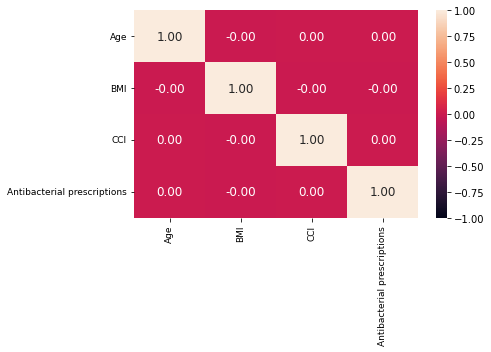

In [35]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_throat[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_throat/corr_throat.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [36]:
data_throat = data_throat[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                                   'antibacterial_brit', 'throat_ab_date', 'ab_type_cat', 'incdt_throat_date', 'date', 'period',
                                   'event_throat_admitted', 'duration_throat_admitted'
                                    ]]

In [37]:
#incident and prevalent infection 
data_throat_incdt = data_throat[data_throat['incdt_throat_date'] == 0]
data_throat_prevl = data_throat[data_throat['incdt_throat_date'] == 1]
#switch variable throat_ab_date into a binary variable
data_throat_incdt[['throat_ab_date']] = data_throat_incdt[['throat_ab_date']].where(data_throat_incdt[['throat_ab_date']].isnull(), 1).fillna(0).astype(int)
data_throat_prevl[['throat_ab_date']] = data_throat_prevl[['throat_ab_date']].where(data_throat_prevl[['throat_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_throat_incdt_males = data_throat_incdt[data_throat_incdt['sex'] == 'male']
data_throat_incdt_females = data_throat_incdt[data_throat_incdt['sex'] == 'female']
data_throat_prevl_males = data_throat_prevl[data_throat_prevl['sex'] == 'male']
data_throat_prevl_females = data_throat_prevl[data_throat_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_throat_incdt_15_24 = data_throat_incdt[data_throat_incdt['age_cat'] == '15_24']
data_throat_incdt_25_34 = data_throat_incdt[data_throat_incdt['age_cat'] == '25_34']
data_throat_incdt_35_44 = data_throat_incdt[data_throat_incdt['age_cat'] == '35_44']
data_throat_incdt_45_54 = data_throat_incdt[data_throat_incdt['age_cat'] == '45_54']
data_throat_incdt_55_64 = data_throat_incdt[data_throat_incdt['age_cat'] == '55_64']
data_throat_incdt_65_74 = data_throat_incdt[data_throat_incdt['age_cat'] == '65_74']
data_throat_incdt_75_more = data_throat_incdt[data_throat_incdt['age_cat'] == '75_more']
data_throat_prevl_15_24 = data_throat_prevl[data_throat_prevl['age_cat'] == '15_24']
data_throat_prevl_25_34 = data_throat_prevl[data_throat_prevl['age_cat'] == '25_34']
data_throat_prevl_35_44 = data_throat_prevl[data_throat_prevl['age_cat'] == '35_44']
data_throat_prevl_45_54 = data_throat_prevl[data_throat_prevl['age_cat'] == '45_54']
data_throat_prevl_55_64 = data_throat_prevl[data_throat_prevl['age_cat'] == '55_64']
data_throat_prevl_65_74 = data_throat_prevl[data_throat_prevl['age_cat'] == '65_74']
data_throat_prevl_75_more = data_throat_prevl[data_throat_prevl['age_cat'] == '75_more']

#incident and prevalent infection stratified by time period categories
data_throat_incdt_prepandemic = data_throat_incdt[data_throat_incdt['date'] <= '2019-12']
data_throat_incdt_during_pandemic = data_throat_incdt[(data_throat_incdt['date'] >= '2020-03') & (data_throat_incdt['date']<= '2021-03')]
data_throat_incdt_post_2nd_lockdown = data_throat_incdt[data_throat_incdt['date'] <= '2021-04']
data_throat_prevl_prepandemic = data_throat_prevl[data_throat_prevl['date'] <= '2019-12']
data_throat_prevl_during_pandemic = data_throat_prevl[(data_throat_prevl['date'] >= '2020-03') & (data_throat_prevl['date']<= '2021-03')]
data_throat_prevl_post_2nd_lockdown = data_throat_prevl[data_throat_prevl['date'] <= '2021-04']

# no antibiotics and incident hospital admission
data_throat_no_abs_incdt = data_throat[data_throat['throat_ab_date'].isnull()]
data_throat_no_abs_incdt = data_throat_no_abs_incdt[data_throat_no_abs_incdt['incdt_throat_date'] == 0]

# with antibiotics and incident hospital admission
data_throat_abs_incdt = data_throat[data_throat['throat_ab_date'].notnull()]
data_throat_abs_incdt = data_throat_abs_incdt[data_throat_abs_incdt['incdt_throat_date'] == 0]

# no antibiotics and prevalent hospital admission
data_throat_no_abs_prevl = data_throat[data_throat['throat_ab_date'].isnull()]
data_throat_no_abs_prevl = data_throat_no_abs_prevl[data_throat_no_abs_prevl['incdt_throat_date'] == 1]

# with antibiotics and prevalent hospital admission
data_throat_abs_prevl = data_throat[data_throat['throat_ab_date'].notnull()]
data_throat_abs_prevl = data_throat_abs_prevl[data_throat_abs_prevl['incdt_throat_date'] == 1]

In [38]:
#store data for plotting hosp admission counts and percentages
%store data_throat
# save data
data_throat.to_csv('../output/hospitalisation_prediction_throat/data_throat.csv')

Stored 'data_throat' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident throat with no antibiotics

<lifelines.CoxPHFitter: fitted with 112782 total observations, 111921 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 112782
number of events observed = 861
   partial log-likelihood = -9992.42
         time fit was run = 2023-02-02 11:02:03 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.07       1.08       0.10            -0.12             0.27                 0.88                 1.32
CCI_cat[T.medium]               -0.08       0.92       0.12            -0.31             0.15                 0.74                 1.16
CCI_cat[T.high]                  0.07       1.08       0.13            -0.19             0.34                 0.83                 1.40
CCI_cat[T.very_high]             0.05       1.05       0.12            -0.18             0.28                 0.83                 1.32
age_cat[T.25_34]                 0.09       1.10       0.13            -0.17             0.35                 0.85                 1.42
age_cat[T.35_44]                 0.23       1.26       0.13            -0.02             0.48                 0.98                 1.62
age_cat[T.45_54]                 0.18       1.20       0.13            -0.07             0.43                 0.93                 1.53
age_cat[T.55_64]                -0.02       0.98       0.13            -0.28             0.24                 0.75                 1.27
age_cat[T.65_74]                -0.02       0.98       0.13            -0.28             0.24                 0.75                 1.28
age_cat[T.75_more]               0.12       1.13       0.13            -0.13             0.38                 0.88                 1.46
antibacterial_brit               0.01       1.01       0.02            -0.04             0.06                 0.96                 1.06
bmi_cat[T.obese]                -0.10       0.91       0.13            -0.34             0.15                 0.71                 1.16
bmi_cat[T.overweight]            0.10       1.10       0.15            -0.19             0.39                 0.82                 1.48
bmi_cat[T.underweight]           0.00       1.00       0.21            -0.41             0.42                 0.66                 1.53
bmi_cat[T.unknown]              -0.05       0.95       0.13            -0.31             0.21                 0.73                 1.24
ethnicity[T.unknown]             0.02       1.03       0.11            -0.19             0.24                 0.82                 1.28
ethnicity[T.white]               0.04       1.04       0.10            -0.15             0.24                 0.86                 1.27
flu_vaccine[T.yes]              -0.05       0.95       0.12            -0.28             0.18                 0.76                 1.19
imd[T.medium]                    0.11       1.12       0.11            -0.11             0.33                 0.89                 1.39
imd[T.unaffluent]                0.07       1.07       0.11            -0.16             0.29                 0.86                 1.33
imd[T.unknown]                   0.06       1.06       0.17            -0.28             0.41                 0.76                 1.50
imd[T.very_affluent]             0.16       1.18       0.11            -0.06             0.38                 0.95                 1.46
imd[T.very_unaffluent]           0.09       1.09       0.11            -0.13             0.31                 0.88                 1.36
region[T.east_midlands]          0.30       1.36       0.15             0.01             0.60                 1.01                 1.83
region[T.london]                 0.17       1.19       0.14  

11946


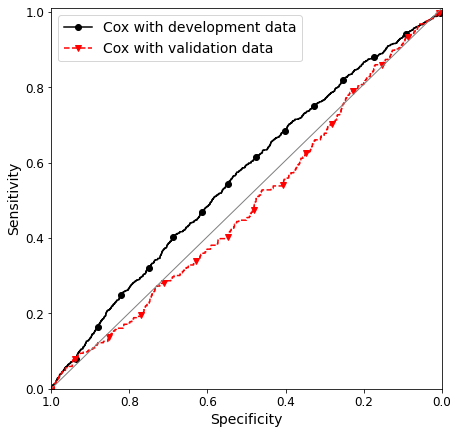

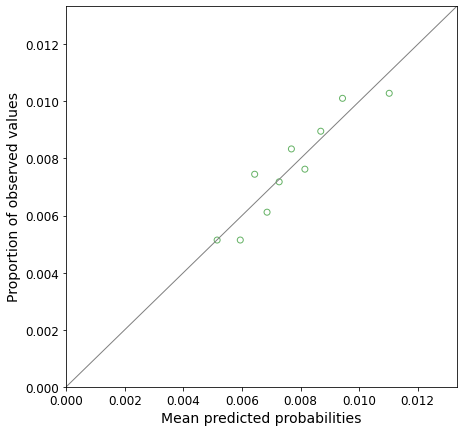

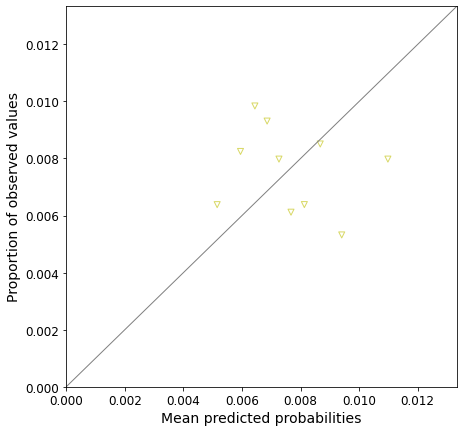

In [39]:
#data prep
data, data_throat_no_abs_incdt_enc = cox_data_prep(data_throat_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#make summary table
make_summary_table('throat', 'no_abs_incdt', data_throat_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('throat', 'no_abs_incdt', data_throat_no_abs_incdt)

try:
    #build cox model 
    cph_throat_no_abs_incdt, data_throat_no_abs_incdt_train, data_throat_no_abs_incdt_test = cox_model_build('throat', 'no_abs_incdt', data_throat_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_throat_no_abs_incdt, '../output/hospitalisation_prediction_throat/', 'betas_cph_throat_no_abs_incdt.csv', data_throat_no_abs_incdt_enc, data_throat_no_abs_incdt, 'sum_betas_cph_throat_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_throat_no_abs_incdt, 'event_throat_admitted', data_throat_no_abs_incdt_train, data_throat_no_abs_incdt_test, '../output/hospitalisation_prediction_throat', 'roc_cph_throat_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_throat_no_abs_incdt, data_throat_no_abs_incdt_train, 'event_throat_admitted', data_throat_no_abs_incdt_test, '../output/hospitalisation_prediction_throat/', 'calibration_cph_throat_no_abs_incdt_train.jpg', 'calibration_cph_throat_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_throat_no_abs_incdt, 'throat', 'no_abs_incdt', data_throat_no_abs_incdt_train, data_throat_no_abs_incdt_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident throat with antibiotics

<lifelines.CoxPHFitter: fitted with 12497 total observations, 12379 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 12497
number of events observed = 118
   partial log-likelihood = -1093.49
         time fit was run = 2023-02-02 11:02:17 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.25       1.29       0.28            -0.30             0.81                 0.74                 2.24
CCI_cat[T.medium]                0.08       1.08       0.32            -0.55             0.70                 0.58                 2.01
CCI_cat[T.high]                 -0.11       0.89       0.40            -0.90             0.67                 0.41                 1.95
CCI_cat[T.very_high]            -0.09       0.91       0.34            -0.77             0.58                 0.46                 1.78
age_cat[T.25_34]                 0.41       1.51       0.41            -0.40             1.22                 0.67                 3.39
age_cat[T.35_44]                 0.53       1.70       0.40            -0.26             1.32                 0.77                 3.75
age_cat[T.45_54]                 0.98       2.67       0.37             0.25             1.71                 1.28                 5.55
age_cat[T.55_64]                 0.09       1.10       0.44            -0.76             0.95                 0.47                 2.59
age_cat[T.65_74]                 0.95       2.60       0.37             0.22             1.69                 1.25                 5.39
age_cat[T.75_more]               0.52       1.69       0.40            -0.27             1.31                 0.77                 3.72
antibacterial_brit              -0.15       0.86       0.07            -0.29            -0.01                 0.75                 0.99
bmi_cat[T.obese]                 0.31       1.36       0.37            -0.42             1.04                 0.65                 2.84
bmi_cat[T.overweight]            0.12       1.12       0.46            -0.78             1.01                 0.46                 2.75
bmi_cat[T.underweight]           0.17       1.18       0.61            -1.04             1.37                 0.35                 3.94
bmi_cat[T.unknown]               0.09       1.09       0.41            -0.71             0.88                 0.49                 2.41
ethnicity[T.unknown]            -0.35       0.70       0.29            -0.93             0.22                 0.40                 1.25
ethnicity[T.white]              -0.24       0.79       0.24            -0.71             0.24                 0.49                 1.28
flu_vaccine[T.yes]               0.29       1.33       0.28            -0.26             0.83                 0.77                 2.29
imd[T.medium]                   -0.07       0.93       0.29            -0.63             0.49                 0.53                 1.63
imd[T.unaffluent]               -0.06       0.94       0.29            -0.62             0.50                 0.54                 1.65
imd[T.unknown]                   0.04       1.04       0.43            -0.80             0.88                 0.45                 2.42
imd[T.very_affluent]            -0.40       0.67       0.31            -1.01             0.22                 0.36                 1.25
imd[T.very_unaffluent]          -0.15       0.86       0.30            -0.73             0.43                 0.48                 1.54
region[T.east_midlands]         -0.02       0.98       0.37            -0.75             0.70                 0.47                 2.02
region[T.london]                -0.20       0.82       0.34     

11962


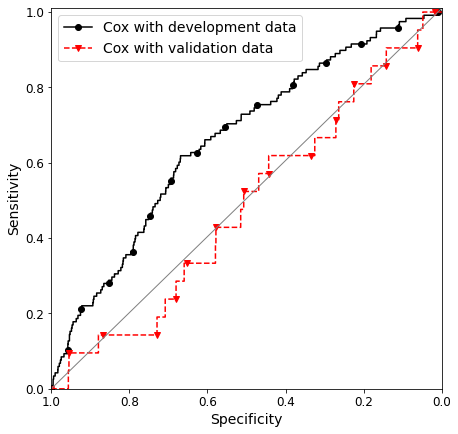

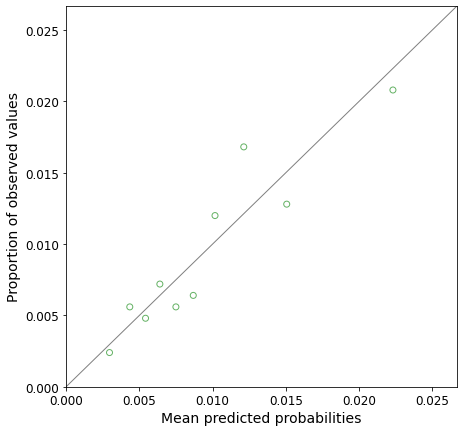

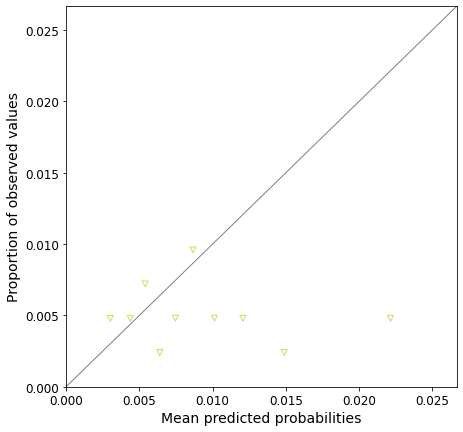

In [40]:
#data prep
data, data_throat_abs_incdt_enc = cox_data_prep(data_throat_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#make summary table
make_summary_table('throat', 'abs_incdt', data_throat_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('throat', 'abs_incdt', data_throat_abs_incdt)

try:
    #build cox model 
    cph_throat_abs_incdt, data_throat_abs_incdt_train, data_throat_abs_incdt_test = cox_model_build('throat', 'abs_incdt', data_throat_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_throat_abs_incdt, '../output/hospitalisation_prediction_throat/', 'betas_cph_throat_abs_incdt.csv', data_throat_abs_incdt_enc, data_throat_abs_incdt, 'sum_betas_cph_throat_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_throat_abs_incdt, 'event_throat_admitted', data_throat_abs_incdt_train, data_throat_abs_incdt_test, '../output/hospitalisation_prediction_throat', 'roc_cph_throat_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_throat_abs_incdt, data_throat_abs_incdt_train, 'event_throat_admitted', data_throat_abs_incdt_test, '../output/hospitalisation_prediction_throat/', 'calibration_cph_throat_abs_incdt_train.jpg', 'calibration_cph_throat_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_throat_abs_incdt, 'throat', 'abs_incdt', data_throat_abs_incdt_train, data_throat_abs_incdt_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent throat with no antibiotics

<lifelines.CoxPHFitter: fitted with 12377 total observations, 12289 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 12377
number of events observed = 88
   partial log-likelihood = -806.96
         time fit was run = 2023-02-02 11:02:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.20       0.82       0.30            -0.80             0.39                 0.45                 1.48
CCI_cat[T.medium]               -0.12       0.89       0.33            -0.76             0.53                 0.47                 1.70
CCI_cat[T.high]                 -0.74       0.48       0.51            -1.74             0.26                 0.18                 1.30
CCI_cat[T.very_high]            -0.10       0.91       0.36            -0.79             0.60                 0.45                 1.82
age_cat[T.25_34]                 0.70       2.01       0.43            -0.15             1.55                 0.86                 4.70
age_cat[T.35_44]                 0.36       1.43       0.46            -0.54             1.26                 0.59                 3.51
age_cat[T.45_54]                 0.72       2.05       0.43            -0.12             1.56                 0.88                 4.75
age_cat[T.55_64]                 0.97       2.63       0.42             0.15             1.78                 1.16                 5.93
age_cat[T.65_74]                -0.15       0.86       0.52            -1.16             0.87                 0.31                 2.39
age_cat[T.75_more]              -0.16       0.85       0.52            -1.17             0.86                 0.31                 2.36
antibacterial_brit              -0.01       0.99       0.08            -0.16             0.13                 0.85                 1.14
bmi_cat[T.obese]                 0.58       1.79       0.47            -0.34             1.50                 0.71                 4.47
bmi_cat[T.overweight]           -0.01       0.99       0.61            -1.19             1.18                 0.30                 3.26
bmi_cat[T.underweight]           0.48       1.61       0.73            -0.96             1.91                 0.38                 6.78
bmi_cat[T.unknown]               0.33       1.38       0.50            -0.66             1.31                 0.52                 3.69
ethnicity[T.unknown]            -0.52       0.60       0.35            -1.21             0.18                 0.30                 1.19
ethnicity[T.white]              -0.15       0.86       0.28            -0.71             0.41                 0.49                 1.51
flu_vaccine[T.yes]              -0.03       0.97       0.35            -0.72             0.67                 0.49                 1.95
imd[T.medium]                    0.06       1.06       0.36            -0.65             0.77                 0.52                 2.15
imd[T.unaffluent]                0.08       1.08       0.36            -0.63             0.78                 0.53                 2.19
imd[T.unknown]                   0.03       1.03       0.56            -1.08             1.13                 0.34                 3.10
imd[T.very_affluent]             0.19       1.21       0.35            -0.50             0.87                 0.61                 2.40
imd[T.very_unaffluent]           0.21       1.23       0.35            -0.47             0.89                 0.63                 2.43
region[T.east_midlands]         -1.04       0.35       0.52            -2.07            -0.02                 0.13                 0.98
region[T.london]                -0.46       0.63       0.36       

11970


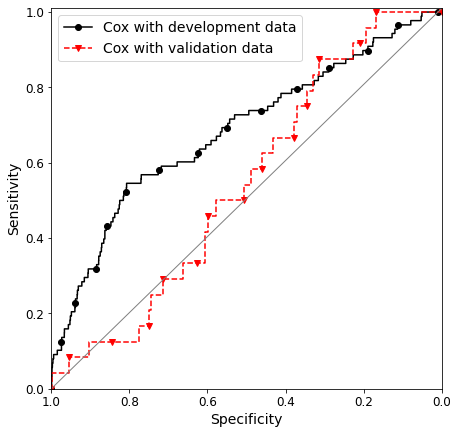

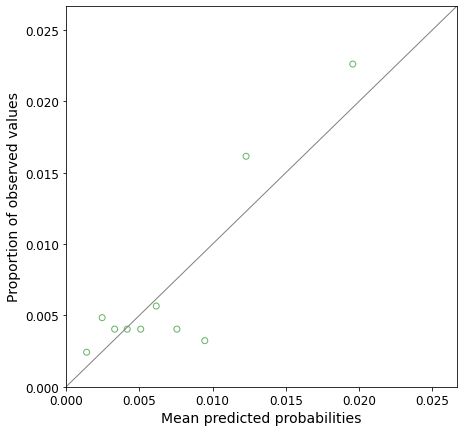

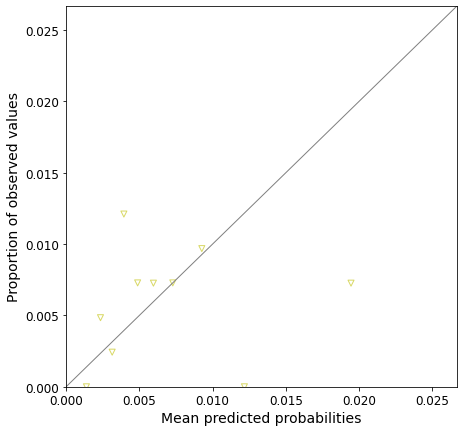

In [41]:
#data prep
data, data_throat_no_abs_prevl_enc = cox_data_prep(data_throat_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#make summary table
make_summary_table('throat', 'no_abs_prevl', data_throat_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('throat', 'no_abs_prevl', data_throat_no_abs_prevl)

try:
    #build cox model 
    cph_throat_no_abs_prevl, data_throat_no_abs_prevl_train, data_throat_no_abs_prevl_test = cox_model_build('throat', 'no_abs_prevl', data_throat_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_throat_no_abs_prevl, '../output/hospitalisation_prediction_throat/', 'betas_cph_throat_no_abs_prevl.csv', data_throat_no_abs_prevl_enc, data_throat_no_abs_prevl, 'sum_betas_cph_throat_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_throat_no_abs_prevl, 'event_throat_admitted', data_throat_no_abs_prevl_train, data_throat_no_abs_prevl_test, '../output/hospitalisation_prediction_throat', 'roc_cph_throat_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_throat_no_abs_prevl, data_throat_no_abs_prevl_train, 'event_throat_admitted', data_throat_no_abs_prevl_test, '../output/hospitalisation_prediction_throat/', 'calibration_cph_throat_no_abs_prevl_train.jpg', 'calibration_cph_throat_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_throat_no_abs_prevl, 'throat', 'no_abs_prevl', data_throat_no_abs_prevl_train, data_throat_no_abs_prevl_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent throat with antibiotics

<lifelines.CoxPHFitter: fitted with 1395 total observations, 1386 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 1395
number of events observed = 9
   partial log-likelihood = -44.16
         time fit was run = 2023-02-02 11:02:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.46       1.59       1.31            -2.10             3.02                 0.12                20.57
CCI_cat[T.medium]                0.62       1.86       1.39            -2.11             3.35                 0.12                28.57
CCI_cat[T.high]                -17.93       0.00    9757.47        -19142.23         19106.36                 0.00                  inf
CCI_cat[T.very_high]             1.28       3.60       1.34            -1.35             3.91                 0.26                50.11
age_cat[T.25_34]                19.14   2.06e+08    8914.40        -17452.75         17491.04                 0.00                  inf
age_cat[T.35_44]                18.94   1.67e+08    8914.40        -17452.96         17490.83                 0.00                  inf
age_cat[T.45_54]                19.48   2.89e+08    8914.40        -17452.41         17491.38                 0.00                  inf
age_cat[T.55_64]                -0.72       0.49   12253.15        -24016.45         24015.01                 0.00                  inf
age_cat[T.65_74]                -0.45       0.64   12722.20        -24935.50         24934.59                 0.00                  inf
age_cat[T.75_more]              17.66   4.69e+07    8914.40        -17454.23         17489.56                 0.00                  inf
antibacterial_brit              -0.25       0.78       0.31            -0.86             0.36                 0.42                 1.44
bmi_cat[T.obese]                -0.24       0.78       1.28            -2.76             2.27                 0.06                 9.72
bmi_cat[T.overweight]            0.88       2.40       1.45            -1.97             3.72                 0.14                41.31
bmi_cat[T.underweight]         -18.24       0.00   11744.30        -23036.63         23000.16                 0.00                  inf
bmi_cat[T.unknown]               0.29       1.34       1.32            -2.30             2.88                 0.10                17.77
ethnicity[T.unknown]            -1.16       0.31       1.55            -4.20             1.88                 0.01                 6.57
ethnicity[T.white]               0.24       1.28       1.21            -2.13             2.62                 0.12                13.68
flu_vaccine[T.yes]               0.95       2.60       0.93            -0.87             2.78                 0.42                16.12
imd[T.medium]                   -0.95       0.39       1.14            -3.18             1.29                 0.04                 3.64
imd[T.unaffluent]               -0.54       0.58       1.04            -2.58             1.50                 0.08                 4.48
imd[T.unknown]                 -19.85       0.00   11906.76        -23356.66         23316.97                 0.00                  inf
imd[T.very_affluent]            -1.86       0.16       1.37            -4.53             0.82                 0.01                 2.27
imd[T.very_unaffluent]          -1.85       0.16       1.40            -4.58             0.89                 0.01                 2.44
region[T.east_midlands]         -0.37       0.69   15862.27        -31089.85         31089.11                 0.00                  inf
region[T.london]                18.30   8.82e+07   12114.82        -237

12242


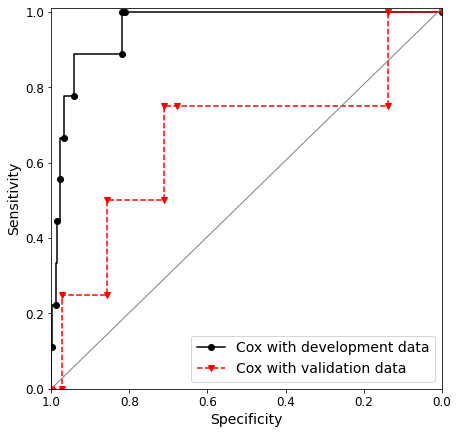

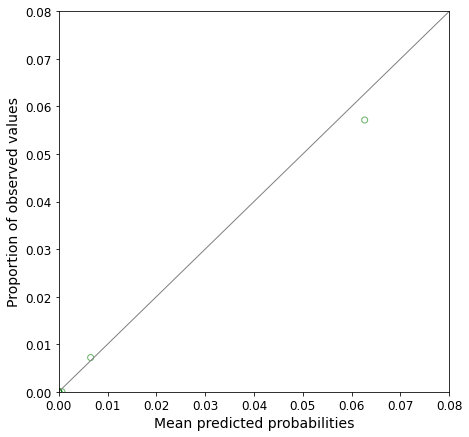

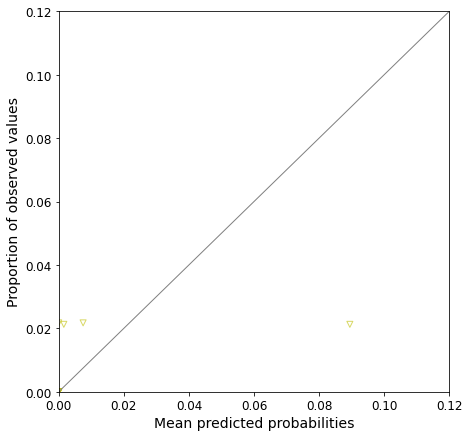

In [42]:
#data prep
data, data_throat_abs_prevl_enc = cox_data_prep(data_throat_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#make summary table
make_summary_table('throat', 'abs_prevl', data_throat_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('throat', 'abs_prevl', data_throat_abs_prevl)

try:
    #build cox model 
    cph_throat_abs_prevl, data_throat_abs_prevl_train, data_throat_abs_prevl_test = cox_model_build('throat', 'abs_prevl', data_throat_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_throat_abs_prevl, '../output/hospitalisation_prediction_throat/', 'betas_cph_throat_abs_prevl.csv', data_throat_abs_prevl_enc, data_throat_abs_prevl, 'sum_betas_cph_throat_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_throat_abs_prevl, 'event_throat_admitted', data_throat_abs_prevl_train, data_throat_abs_prevl_test, '../output/hospitalisation_prediction_throat', 'roc_cph_throat_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_throat_abs_prevl, data_throat_abs_prevl_train, 'event_throat_admitted', data_throat_abs_prevl_test, '../output/hospitalisation_prediction_throat/', 'calibration_cph_throat_abs_prevl_train.jpg', 'calibration_cph_throat_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_throat_abs_prevl, 'throat', 'abs_prevl', data_throat_abs_prevl_train, data_throat_abs_prevl_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident throat

In [43]:
#data prep
data, data_throat_incdt_enc = cox_data_prep(data_throat_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#make summary tables from preped data
make_summary_table('throat', 'incdt', data_throat_incdt_enc)
make_summary_table_hosped('throat', 'incdt', data_throat_incdt)

try:
    cph_throat_incdt, data_throat_incdt_train, data_throat_incdt_test = cox_model_abs_build('throat', 'incdt', data_throat_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_throat_incdt, 'throat', 'incdt', data_throat_incdt_train, data_throat_incdt_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 125280 total observations, 124315 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 125280
number of events observed = 965
   partial log-likelihood = -11306.59
         time fit was run = 2023-02-02 11:02:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.01       1.01       0.09            -0.17             0.20                 0.84                 1.22
CCI_cat[T.medium]               -0.08       0.93       0.11            -0.29             0.13                 0.75                 1.14
CCI_cat[T.high]                 -0.02       0.98       0.13            -0.26             0.23                 0.77                 1.26
CCI_cat[T.very_high]            -0.02       0.98       0.11            -0.24             0.20                 0.79                 1.22
age_cat[T.25_34]                 0.08       1.08       0.12            -0.16             0.32                 0.85                 1.37
age_cat[T.35_44]                 0.22       1.24       0.12            -0.01             0.45                 0.99                 1.56
age_cat[T.45_54]                 0.08       1.08       0.12            -0.16             0.31                 0.85                 1.37
age_cat[T.55_64]                -0.10       0.90       0.13            -0.35             0.15                 0.71                 1.16
age_cat[T.65_74]                 0.05       1.05       0.12            -0.19             0.29                 0.83                 1.33
age_cat[T.75_more]              -0.03       0.97       0.12            -0.27             0.22                 0.76                 1.24
antibacterial_brit              -0.03       0.97       0.02            -0.08             0.01                 0.92                 1.01
bmi_cat[T.obese]                -0.11       0.90       0.12            -0.34             0.12                 0.71                 1.13
bmi_cat[T.overweight]            0.07       1.07       0.14            -0.21             0.35                 0.81                 1.41
bmi_cat[T.underweight]          -0.15       0.86       0.21            -0.56             0.27                 0.57                 1.31
bmi_cat[T.unknown]              -0.03       0.97       0.13            -0.28             0.22                 0.76                 1.24
ethnicity[T.unknown]            -0.10       0.90       0.10            -0.31             0.10                 0.74                 1.10
ethnicity[T.white]              -0.06       0.94       0.09            -0.24             0.11                 0.79                 1.12
flu_vaccine[T.yes]               0.05       1.05       0.11            -0.16             0.25                 0.85                 1.29
imd[T.medium]                    0.03       1.03       0.10            -0.18             0.23                 0.84                 1.26
imd[T.unaffluent]               -0.05       0.95       0.11            -0.26             0.15                 0.77                 1.17
imd[T.unknown]                   0.12       1.13       0.15            -0.18             0.43                 0.84                 1.53
imd[T.very_affluent]             0.03       1.03       0.10            -0.17             0.24                 0.84                 1.27
imd[T.very_unaffluent]          -0.08       0.92       0.11            -0.29             0.13                 0.75                 1.14
region[T.east_midlands]          0.17       1.18       0.15            -0.13             0.46                 0.88                 1.59
region[T.london]                 0.25       1.28       0.13 

12207


### 5-6- hospital admission related to prevalent throat

In [44]:
#data prep
data, data_throat_prevl_enc = cox_data_prep(data_throat_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#make summary tables from preped data
make_summary_table('throat', 'prevl', data_throat_prevl_enc)
make_summary_table_hosped('throat', 'prevl', data_throat_prevl)

try:
    cph_throat_prevl, data_throat_prevl_train, data_throat_prevl_test = cox_model_abs_build('throat', 'prevl', data_throat_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_throat_prevl, 'throat', 'prevl', data_throat_prevl_train, data_throat_prevl_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13772 total observations, 13682 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 13772
number of events observed = 90
   partial log-likelihood = -832.53
         time fit was run = 2023-02-02 11:02:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.24       0.79       0.30            -0.83             0.36                 0.44                 1.44
CCI_cat[T.medium]               -0.01       0.99       0.32            -0.65             0.62                 0.52                 1.86
CCI_cat[T.high]                 -0.79       0.46       0.51            -1.78             0.21                 0.17                 1.24
CCI_cat[T.very_high]            -0.05       0.95       0.35            -0.74             0.63                 0.48                 1.88
age_cat[T.25_34]                 0.80       2.22       0.43            -0.04             1.63                 0.96                 5.12
age_cat[T.35_44]                 0.48       1.62       0.45            -0.40             1.37                 0.67                 3.92
age_cat[T.45_54]                 0.78       2.17       0.43            -0.06             1.61                 0.94                 5.00
age_cat[T.55_64]                 0.77       2.16       0.43            -0.07             1.61                 0.93                 5.01
age_cat[T.65_74]                -0.18       0.84       0.52            -1.19             0.84                 0.30                 2.32
age_cat[T.75_more]               0.09       1.10       0.49            -0.86             1.05                 0.42                 2.85
antibacterial_brit               0.06       1.06       0.07            -0.08             0.20                 0.92                 1.22
bmi_cat[T.obese]                 0.23       1.26       0.40            -0.56             1.02                 0.57                 2.77
bmi_cat[T.overweight]           -0.39       0.68       0.56            -1.48             0.70                 0.23                 2.02
bmi_cat[T.underweight]          -0.35       0.71       0.80            -1.92             1.23                 0.15                 3.42
bmi_cat[T.unknown]              -0.10       0.90       0.44            -0.97             0.76                 0.38                 2.15
ethnicity[T.unknown]            -0.46       0.63       0.39            -1.21             0.30                 0.30                 1.35
ethnicity[T.white]               0.17       1.19       0.31            -0.43             0.77                 0.65                 2.16
flu_vaccine[T.yes]               0.09       1.09       0.34            -0.57             0.75                 0.56                 2.11
imd[T.medium]                    0.11       1.12       0.33            -0.54             0.77                 0.58                 2.15
imd[T.unaffluent]               -0.09       0.91       0.35            -0.79             0.60                 0.45                 1.83
imd[T.unknown]                  -0.41       0.66       0.63            -1.64             0.82                 0.19                 2.26
imd[T.very_affluent]            -0.02       0.98       0.34            -0.69             0.66                 0.50                 1.93
imd[T.very_unaffluent]           0.07       1.07       0.33            -0.59             0.73                 0.56                 2.07
region[T.east_midlands]         -1.74       0.17       0.76            -3.24            -0.25                 0.04                 0.78
region[T.london]                -0.02       0.98       0.36       

12220


### 5-7- hospital admission related to incident throat with prescribed antibiotics categories

In [45]:
#data prep
data, data_throat_incdt_abs_enc = cox_data_prep(data_throat_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_abs, data_throat_incdt_abs_train, data_throat_incdt_abs_test = cox_model_ab_type_build('throat', 'incdt_ab_type', data_throat_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_throat_incdt_abs, 'throat', 'incdt_abs', data_throat_incdt_abs_train, data_throat_incdt_abs_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 125280 total observations, 124315 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 125280
number of events observed = 965
   partial log-likelihood = -11306.50
         time fit was run = 2023-02-02 11:02:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.01       1.01       0.09            -0.17             0.20                 0.84                 1.22
CCI_cat[T.medium]               -0.08       0.93       0.11            -0.29             0.13                 0.75                 1.14
CCI_cat[T.high]                 -0.02       0.98       0.13            -0.26             0.23                 0.77                 1.26
CCI_cat[T.very_high]            -0.02       0.98       0.11            -0.24             0.20                 0.79                 1.22
ab_type_cat[T.Doxycycline]       0.25       1.29       0.84            -1.39             1.90                 0.25                 6.65
ab_type_cat[T.no]                0.18       1.20       0.45            -0.70             1.06                 0.50                 2.89
ab_type_cat[T.other]             0.19       1.21       0.46            -0.71             1.09                 0.49                 2.99
age_cat[T.25_34]                 0.08       1.08       0.12            -0.16             0.32                 0.85                 1.37
age_cat[T.35_44]                 0.22       1.24       0.12            -0.01             0.45                 0.99                 1.56
age_cat[T.45_54]                 0.08       1.08       0.12            -0.16             0.31                 0.85                 1.37
age_cat[T.55_64]                -0.10       0.90       0.13            -0.35             0.15                 0.71                 1.16
age_cat[T.65_74]                 0.05       1.05       0.12            -0.19             0.29                 0.83                 1.33
age_cat[T.75_more]              -0.03       0.97       0.12            -0.27             0.22                 0.76                 1.24
antibacterial_brit              -0.03       0.97       0.02            -0.08             0.01                 0.92                 1.01
bmi_cat[T.obese]                -0.11       0.90       0.12            -0.34             0.12                 0.71                 1.13
bmi_cat[T.overweight]            0.07       1.07       0.14            -0.21             0.35                 0.81                 1.41
bmi_cat[T.underweight]          -0.15       0.86       0.21            -0.56             0.27                 0.57                 1.31
bmi_cat[T.unknown]              -0.03       0.97       0.13            -0.27             0.22                 0.76                 1.24
ethnicity[T.unknown]            -0.10       0.90       0.10            -0.31             0.10                 0.74                 1.10
ethnicity[T.white]              -0.06       0.94       0.09            -0.24             0.11                 0.79                 1.12
flu_vaccine[T.yes]               0.05       1.05       0.11            -0.16             0.25                 0.85                 1.29
imd[T.medium]                    0.03       1.03       0.10            -0.18             0.23                 0.84                 1.26
imd[T.unaffluent]               -0.05       0.95       0.11            -0.26             0.15                 0.77                 1.17
imd[T.unknown]                   0.12       1.13       0.15            -0.18             0.43                 0.84                 1.53
imd[T.very_affluent]             0.03       1.03       0.10 

12728


### 5-8- hospital admission related to prevalent throat with prescribed antibiotics categories

In [46]:
#data prep
data, data_throat_prevl_abs_enc = cox_data_prep(data_throat_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_prevl_abs, data_throat_prevl_abs_train, data_throat_prevl_abs_test = cox_model_ab_type_build('throat', 'prevl_ab_type', data_throat_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_throat_prevl_abs, 'throat', 'prevl_abs', data_throat_prevl_abs_train, data_throat_prevl_abs_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13772 total observations, 13682 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 13772
number of events observed = 90
   partial log-likelihood = -831.48
         time fit was run = 2023-02-02 11:02:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.24       0.79       0.30            -0.83             0.36                 0.44                 1.43
CCI_cat[T.medium]               -0.02       0.98       0.32            -0.65             0.62                 0.52                 1.86
CCI_cat[T.high]                 -0.79       0.46       0.51            -1.79             0.21                 0.17                 1.24
CCI_cat[T.very_high]            -0.05       0.95       0.35            -0.74             0.63                 0.48                 1.89
ab_type_cat[T.Doxycycline]       0.21       1.23    4167.64         -8168.22          8168.63                 0.00                  inf
ab_type_cat[T.no]               14.96   3.15e+06    2282.83         -4459.31          4489.23                 0.00                  inf
ab_type_cat[T.other]            15.26   4.24e+06    2282.83         -4459.01          4489.53                 0.00                  inf
age_cat[T.25_34]                 0.80       2.23       0.43            -0.03             1.64                 0.97                 5.13
age_cat[T.35_44]                 0.49       1.63       0.45            -0.40             1.37                 0.67                 3.93
age_cat[T.45_54]                 0.77       2.17       0.43            -0.06             1.61                 0.94                 4.99
age_cat[T.55_64]                 0.77       2.17       0.43            -0.07             1.62                 0.93                 5.03
age_cat[T.65_74]                -0.18       0.83       0.52            -1.20             0.83                 0.30                 2.30
age_cat[T.75_more]               0.10       1.10       0.49            -0.86             1.05                 0.42                 2.86
antibacterial_brit               0.06       1.06       0.07            -0.08             0.20                 0.92                 1.23
bmi_cat[T.obese]                 0.23       1.26       0.40            -0.56             1.02                 0.57                 2.77
bmi_cat[T.overweight]           -0.39       0.68       0.56            -1.48             0.70                 0.23                 2.02
bmi_cat[T.underweight]          -0.35       0.71       0.80            -1.92             1.23                 0.15                 3.42
bmi_cat[T.unknown]              -0.10       0.90       0.44            -0.97             0.76                 0.38                 2.15
ethnicity[T.unknown]            -0.46       0.63       0.39            -1.22             0.30                 0.30                 1.34
ethnicity[T.white]               0.17       1.18       0.31            -0.43             0.76                 0.65                 2.15
flu_vaccine[T.yes]               0.08       1.08       0.34            -0.58             0.74                 0.56                 2.09
imd[T.medium]                    0.11       1.11       0.33            -0.55             0.76                 0.58                 2.15
imd[T.unaffluent]               -0.09       0.91       0.35            -0.79             0.60                 0.45                 1.83
imd[T.unknown]                  -0.42       0.66       0.63            -1.64             0.81                 0.19                 2.26
imd[T.very_affluent]            -0.01       0.99       0.34       

12775


### 5-9- stratified by sex
#### 5-9-1- incident males

In [47]:
#data prep
data, data_throat_incdt_males_enc = cox_data_prep(data_throat_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_males, data_throat_incdt_males_train, data_throat_incdt_males_test = cox_model_strat_sex_build('throat', 'incdt_males', data_throat_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_throat_incdt_males, 'throat', 'incdt_males', data_throat_incdt_males_train, data_throat_incdt_males_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 61727 total observations, 61226 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 61727
number of events observed = 501
   partial log-likelihood = -5510.94
         time fit was run = 2023-02-02 11:03:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.04       1.04       0.13            -0.22             0.30                 0.80                 1.35
CCI_cat[T.medium]               -0.10       0.91       0.15            -0.39             0.20                 0.67                 1.22
CCI_cat[T.high]                  0.07       1.07       0.17            -0.27             0.41                 0.76                 1.50
CCI_cat[T.very_high]             0.07       1.07       0.15            -0.23             0.37                 0.79                 1.44
age_cat[T.25_34]                 0.02       1.02       0.17            -0.32             0.36                 0.73                 1.43
age_cat[T.35_44]                 0.24       1.27       0.16            -0.08             0.56                 0.93                 1.75
age_cat[T.45_54]                 0.06       1.06       0.17            -0.27             0.39                 0.76                 1.47
age_cat[T.55_64]                -0.02       0.98       0.17            -0.36             0.32                 0.70                 1.37
age_cat[T.65_74]                 0.11       1.12       0.17            -0.22             0.44                 0.80                 1.55
age_cat[T.75_more]              -0.11       0.89       0.18            -0.46             0.23                 0.63                 1.26
antibacterial_brit               0.01       1.01       0.03            -0.05             0.07                 0.95                 1.08
bmi_cat[T.obese]                -0.23       0.79       0.16            -0.54             0.07                 0.58                 1.08
bmi_cat[T.overweight]           -0.18       0.83       0.20            -0.57             0.20                 0.57                 1.22
bmi_cat[T.underweight]          -0.10       0.91       0.28            -0.64             0.44                 0.53                 1.56
bmi_cat[T.unknown]              -0.11       0.90       0.17            -0.44             0.22                 0.65                 1.24
ethnicity[T.unknown]            -0.05       0.95       0.14            -0.33             0.23                 0.72                 1.26
ethnicity[T.white]              -0.09       0.91       0.13            -0.34             0.16                 0.71                 1.17
flu_vaccine[T.yes]              -0.04       0.96       0.15            -0.33             0.26                 0.72                 1.30
imd[T.medium]                    0.03       1.03       0.15            -0.27             0.32                 0.77                 1.38
imd[T.unaffluent]                0.17       1.18       0.14            -0.11             0.45                 0.89                 1.57
imd[T.unknown]                   0.16       1.18       0.22            -0.26             0.59                 0.77                 1.80
imd[T.very_affluent]             0.11       1.12       0.15            -0.17             0.40                 0.84                 1.49
imd[T.very_unaffluent]          -0.02       0.99       0.15            -0.31             0.28                 0.73                 1.32
region[T.east_midlands]          0.44       1.56       0.20             0.05             0.83                 1.05                 2.30
region[T.london]                 0.15       1.16       0.19     

11956


#### 5-9-2- incident females

In [48]:
#data prep
data, data_throat_incdt_females_enc = cox_data_prep(data_throat_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_females, data_throat_incdt_females_train, data_throat_incdt_females_test = cox_model_strat_sex_build('throat', 'incdt_females', data_throat_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_throat_incdt_females, 'throat', 'incdt_females', data_throat_incdt_females_train, data_throat_incdt_females_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 63552 total observations, 63076 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 63552
number of events observed = 476
   partial log-likelihood = -5245.25
         time fit was run = 2023-02-02 11:03:04 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.16       0.85       0.13            -0.41             0.09                 0.66                 1.10
CCI_cat[T.medium]               -0.19       0.82       0.15            -0.48             0.09                 0.62                 1.10
CCI_cat[T.high]                 -0.07       0.93       0.17            -0.40             0.27                 0.67                 1.30
CCI_cat[T.very_high]            -0.37       0.69       0.16            -0.69            -0.06                 0.50                 0.94
age_cat[T.25_34]                 0.15       1.17       0.17            -0.18             0.49                 0.83                 1.63
age_cat[T.35_44]                 0.21       1.23       0.17            -0.13             0.54                 0.88                 1.71
age_cat[T.45_54]                 0.21       1.23       0.17            -0.12             0.54                 0.89                 1.72
age_cat[T.55_64]                -0.18       0.84       0.19            -0.54             0.18                 0.58                 1.20
age_cat[T.65_74]                -0.20       0.82       0.19            -0.57             0.16                 0.57                 1.18
age_cat[T.75_more]               0.20       1.22       0.17            -0.13             0.53                 0.88                 1.70
antibacterial_brit               0.01       1.01       0.03            -0.05             0.07                 0.95                 1.08
bmi_cat[T.obese]                 0.09       1.09       0.18            -0.27             0.44                 0.77                 1.56
bmi_cat[T.overweight]            0.38       1.46       0.21            -0.03             0.78                 0.97                 2.19
bmi_cat[T.underweight]          -0.04       0.96       0.32            -0.66             0.58                 0.52                 1.78
bmi_cat[T.unknown]               0.06       1.07       0.19            -0.31             0.44                 0.73                 1.56
ethnicity[T.unknown]             0.02       1.02       0.15            -0.27             0.31                 0.77                 1.37
ethnicity[T.white]              -0.04       0.97       0.13            -0.29             0.22                 0.75                 1.25
flu_vaccine[T.yes]               0.05       1.06       0.15            -0.24             0.35                 0.79                 1.42
imd[T.medium]                    0.13       1.13       0.15            -0.16             0.41                 0.85                 1.51
imd[T.unaffluent]               -0.07       0.93       0.15            -0.37             0.23                 0.69                 1.25
imd[T.unknown]                  -0.02       0.98       0.23            -0.48             0.44                 0.62                 1.55
imd[T.very_affluent]            -0.01       0.99       0.15            -0.30             0.28                 0.74                 1.32
imd[T.very_unaffluent]          -0.03       0.97       0.15            -0.32             0.27                 0.73                 1.31
region[T.east_midlands]         -0.10       0.90       0.21            -0.51             0.31                 0.60                 1.36
region[T.london]                 0.05       1.05       0.17     

11970


#### 5-9-3- prevalent males

In [49]:
#data prep
data, data_throat_prevl_males_enc = cox_data_prep(data_throat_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_prevl_males, data_throat_prevl_males_train, data_throat_prevl_males_test = cox_model_strat_sex_build('throat', 'prevl_males', data_throat_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cox_output(cph_throat_prevl_males, 'throat', 'prevl_males', data_throat_prevl_males_train, data_throat_prevl_males_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6718 total observations, 6669 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 6718
number of events observed = 49
   partial log-likelihood = -414.92
         time fit was run = 2023-02-02 11:03:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.26       0.77       0.40            -1.05             0.52                 0.35                 1.69
CCI_cat[T.medium]               -0.28       0.75       0.46            -1.19             0.63                 0.30                 1.87
CCI_cat[T.high]                 -0.73       0.48       0.66            -2.02             0.56                 0.13                 1.76
CCI_cat[T.very_high]             0.17       1.18       0.45            -0.72             1.05                 0.49                 2.87
age_cat[T.25_34]                 1.37       3.94       0.79            -0.18             2.93                 0.83                18.67
age_cat[T.35_44]                 1.71       5.54       0.77             0.20             3.22                 1.22                25.12
age_cat[T.45_54]                 1.38       3.96       0.79            -0.18             2.93                 0.84                18.72
age_cat[T.55_64]                 1.58       4.88       0.78             0.06             3.11                 1.06                22.35
age_cat[T.65_74]                 0.89       2.43       0.84            -0.75             2.53                 0.47                12.59
age_cat[T.75_more]               0.84       2.32       0.84            -0.80             2.48                 0.45                11.99
antibacterial_brit               0.03       1.03       0.10            -0.17             0.22                 0.84                 1.25
bmi_cat[T.obese]                -0.02       0.98       0.54            -1.08             1.05                 0.34                 2.84
bmi_cat[T.overweight]           -0.11       0.90       0.67            -1.43             1.21                 0.24                 3.35
bmi_cat[T.underweight]           0.49       1.63       0.77            -1.02             2.00                 0.36                 7.41
bmi_cat[T.unknown]               0.10       1.11       0.57            -1.02             1.23                 0.36                 3.41
ethnicity[T.unknown]             0.23       1.26       0.54            -0.83             1.29                 0.44                 3.65
ethnicity[T.white]               0.49       1.63       0.48            -0.45             1.43                 0.63                 4.19
flu_vaccine[T.yes]               0.25       1.28       0.44            -0.61             1.11                 0.54                 3.03
imd[T.medium]                    0.34       1.41       0.44            -0.52             1.21                 0.59                 3.35
imd[T.unaffluent]                0.03       1.03       0.47            -0.89             0.96                 0.41                 2.61
imd[T.unknown]                  -0.14       0.87       0.78            -1.67             1.40                 0.19                 4.05
imd[T.very_affluent]            -0.08       0.92       0.49            -1.04             0.87                 0.35                 2.39
imd[T.very_unaffluent]          -0.04       0.96       0.47            -0.97             0.89                 0.38                 2.42
region[T.east_midlands]         -0.59       0.55       0.63            -1.83             0.65                 0.16                 1.91
region[T.london]                -0.17       0.85       0.48          

11969


#### 5-9-4- prevalent females

In [50]:
try:
    #data prep
    data, data_throat_prevl_females_enc = cox_data_prep(data_throat_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

    #cox model
    cph_throat_prevl_females, data_throat_prevl_females_train, data_throat_prevl_females_test = cox_model_strat_sex_build('throat', 'prevl_females', data_throat_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_throat_prevl_females, 'throat', 'prevl_females', data_throat_prevl_females_train, data_throat_prevl_females_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7053 total observations, 7003 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 7053
number of events observed = 50
   partial log-likelihood = -425.82
         time fit was run = 2023-02-02 11:03:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.43            -0.90             0.79                 0.41                 2.19
CCI_cat[T.medium]                0.16       1.17       0.45            -0.72             1.05                 0.48                 2.85
CCI_cat[T.high]                 -0.31       0.73       0.61            -1.52             0.89                 0.22                 2.43
CCI_cat[T.very_high]            -0.15       0.86       0.50            -1.14             0.83                 0.32                 2.29
age_cat[T.25_34]                 0.14       1.15       0.52            -0.88             1.16                 0.42                 3.18
age_cat[T.35_44]                -0.40       0.67       0.59            -1.55             0.75                 0.21                 2.11
age_cat[T.45_54]                 0.46       1.58       0.49            -0.49             1.41                 0.61                 4.09
age_cat[T.55_64]                 0.22       1.25       0.51            -0.77             1.22                 0.46                 3.37
age_cat[T.65_74]                -0.23       0.80       0.56            -1.32             0.87                 0.27                 2.38
age_cat[T.75_more]              -0.59       0.56       0.63            -1.82             0.65                 0.16                 1.91
antibacterial_brit               0.05       1.05       0.10            -0.15             0.24                 0.86                 1.27
bmi_cat[T.obese]                 0.25       1.29       0.53            -0.79             1.30                 0.45                 3.65
bmi_cat[T.overweight]           -0.94       0.39       0.87            -2.65             0.76                 0.07                 2.14
bmi_cat[T.underweight]         -15.86       0.00    2316.06         -4555.26          4523.54                 0.00                  inf
bmi_cat[T.unknown]              -0.19       0.83       0.59            -1.34             0.96                 0.26                 2.61
ethnicity[T.unknown]            -0.58       0.56       0.50            -1.56             0.40                 0.21                 1.50
ethnicity[T.white]              -0.00       1.00       0.39            -0.78             0.77                 0.46                 2.16
flu_vaccine[T.yes]              -0.61       0.55       0.60            -1.78             0.57                 0.17                 1.76
imd[T.medium]                   -0.23       0.80       0.48            -1.16             0.71                 0.31                 2.03
imd[T.unaffluent]               -0.52       0.59       0.52            -1.54             0.49                 0.21                 1.63
imd[T.unknown]                  -1.02       0.36       1.05            -3.08             1.04                 0.05                 2.83
imd[T.very_affluent]             0.09       1.09       0.43            -0.76             0.93                 0.47                 2.54
imd[T.very_unaffluent]           0.22       1.25       0.42            -0.61             1.05                 0.55                 2.86
region[T.east_midlands]         -1.06       0.34       0.82            -2.67             0.54                 0.07                 1.71
region[T.london]                -0.30       0.74       0.53          

11985


### 5-10- stratified by age category
#### 5-10-1- incident

In [51]:
#data prep
data, data_throat_incdt_15_24_enc = cox_data_prep(data_throat_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_15_24, data_throat_incdt_15_24_train, data_throat_incdt_15_24_test = cox_model_strat_age_build('throat', 'incdt_15_24', data_throat_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_throat_incdt_15_24, 'throat', 'incdt_15_24', data_throat_incdt_15_24_train, data_throat_incdt_15_24_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17943 total observations, 17823 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 17943
number of events observed = 120
   partial log-likelihood = -1150.41
         time fit was run = 2023-02-02 11:03:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.51       1.66       0.29            -0.07             1.08                 0.94                 2.94
CCI_cat[T.medium]                0.00       1.00       0.35            -0.68             0.69                 0.51                 1.99
CCI_cat[T.high]                  0.31       1.37       0.38            -0.43             1.06                 0.65                 2.88
CCI_cat[T.very_high]             0.25       1.29       0.34            -0.42             0.92                 0.66                 2.52
antibacterial_brit              -0.05       0.96       0.07            -0.17             0.08                 0.84                 1.09
bmi_cat[T.obese]                -0.83       0.44       0.28            -1.37            -0.29                 0.25                 0.75
bmi_cat[T.overweight]           -0.62       0.54       0.36            -1.33             0.10                 0.26                 1.10
bmi_cat[T.underweight]          -0.91       0.40       0.62            -2.13             0.32                 0.12                 1.37
bmi_cat[T.unknown]              -0.37       0.69       0.29            -0.94             0.19                 0.39                 1.21
ethnicity[T.unknown]             0.21       1.23       0.30            -0.38             0.79                 0.69                 2.20
ethnicity[T.white]               0.03       1.03       0.27            -0.51             0.56                 0.60                 1.75
flu_vaccine[T.yes]              -0.02       0.98       0.31            -0.62             0.58                 0.54                 1.79
imd[T.medium]                   -0.16       0.85       0.29            -0.73             0.41                 0.48                 1.51
imd[T.unaffluent]               -0.21       0.81       0.30            -0.79             0.37                 0.45                 1.45
imd[T.unknown]                   0.50       1.65       0.36            -0.21             1.21                 0.81                 3.36
imd[T.very_affluent]            -0.11       0.89       0.29            -0.68             0.45                 0.51                 1.57
imd[T.very_unaffluent]          -0.33       0.72       0.31            -0.93             0.28                 0.39                 1.32
region[T.east_midlands]         -0.48       0.62       0.38            -1.24             0.27                 0.29                 1.30
region[T.london]                -0.46       0.63       0.32            -1.08             0.17                 0.34                 1.18
region[T.north_east]            -0.29       0.75       0.36            -1.00             0.43                 0.37                 1.54
region[T.north_west]            -1.28       0.28       0.51            -2.27            -0.29                 0.10                 0.75
region[T.south_east]            -0.23       0.79       0.36            -0.93             0.47                 0.39                 1.60
region[T.south_west]            -0.34       0.71       0.36            -1.05             0.38                 0.35                 1.46
region[T.west_midlands]          0.04       1.04       0.33            -0.61             0.70                 0.54                 2.01
region[T.yorkshire]             -1.02       0.36       0.47     

10711


In [52]:
#data prep
data, data_throat_incdt_25_34_enc = cox_data_prep(data_throat_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_25_34, data_throat_incdt_25_34_train, data_throat_incdt_25_34_test = cox_model_strat_age_build('throat', 'incdt_25_34', data_throat_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_throat_incdt_25_34, 'throat', 'incdt_25_34', data_throat_incdt_25_34_train, data_throat_incdt_25_34_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17502 total observations, 17364 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 17502
number of events observed = 138
   partial log-likelihood = -1333.17
         time fit was run = 2023-02-02 11:03:13 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.01       1.01       0.25            -0.48             0.50                 0.62                 1.64
CCI_cat[T.medium]               -0.13       0.87       0.28            -0.69             0.42                 0.50                 1.52
CCI_cat[T.high]                 -0.02       0.98       0.33            -0.66             0.63                 0.52                 1.88
CCI_cat[T.very_high]            -0.07       0.94       0.30            -0.65             0.51                 0.52                 1.67
antibacterial_brit              -0.04       0.96       0.06            -0.16             0.08                 0.85                 1.08
bmi_cat[T.obese]                 0.01       1.01       0.31            -0.60             0.62                 0.55                 1.87
bmi_cat[T.overweight]            0.21       1.23       0.37            -0.52             0.93                 0.60                 2.53
bmi_cat[T.underweight]          -0.03       0.97       0.53            -1.08             1.01                 0.34                 2.76
bmi_cat[T.unknown]              -0.20       0.82       0.34            -0.87             0.48                 0.42                 1.61
ethnicity[T.unknown]             0.37       1.44       0.31            -0.24             0.97                 0.79                 2.63
ethnicity[T.white]               0.36       1.43       0.28            -0.19             0.91                 0.83                 2.48
flu_vaccine[T.yes]               0.10       1.11       0.27            -0.42             0.63                 0.66                 1.87
imd[T.medium]                    0.38       1.46       0.27            -0.15             0.91                 0.86                 2.48
imd[T.unaffluent]                0.22       1.24       0.28            -0.33             0.77                 0.72                 2.15
imd[T.unknown]                  -0.48       0.62       0.54            -1.54             0.58                 0.21                 1.79
imd[T.very_affluent]             0.14       1.15       0.28            -0.41             0.70                 0.66                 2.01
imd[T.very_unaffluent]          -0.16       0.85       0.31            -0.76             0.44                 0.47                 1.55
region[T.east_midlands]          0.30       1.35       0.40            -0.48             1.08                 0.62                 2.93
region[T.london]                 0.05       1.05       0.36            -0.66             0.76                 0.51                 2.15
region[T.north_east]             0.32       1.38       0.39            -0.45             1.09                 0.64                 2.97
region[T.north_west]             0.67       1.95       0.37            -0.06             1.39                 0.94                 4.02
region[T.south_east]             0.24       1.27       0.40            -0.55             1.03                 0.58                 2.80
region[T.south_west]            -0.15       0.86       0.43            -0.99             0.68                 0.37                 1.98
region[T.west_midlands]         -0.19       0.82       0.44            -1.05             0.66                 0.35                 1.94
region[T.yorkshire]              0.25       1.28       0.40     

10697


In [53]:
#data prep
data, data_throat_incdt_35_44_enc = cox_data_prep(data_throat_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_35_44, data_throat_incdt_35_44_train, data_throat_incdt_35_44_test = cox_model_strat_age_build('throat', 'incdt_35_44', data_throat_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_throat_incdt_35_44, 'throat', 'incdt_35_44', data_throat_incdt_35_44_train, data_throat_incdt_35_44_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17829 total observations, 17677 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 17829
number of events observed = 152
   partial log-likelihood = -1472.22
         time fit was run = 2023-02-02 11:03:16 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.19       0.83       0.24            -0.66             0.28                 0.52                 1.33
CCI_cat[T.medium]                0.15       1.17       0.25            -0.34             0.64                 0.72                 1.90
CCI_cat[T.high]                 -0.73       0.48       0.40            -1.52             0.06                 0.22                 1.06
CCI_cat[T.very_high]             0.04       1.04       0.27            -0.49             0.57                 0.61                 1.77
antibacterial_brit               0.03       1.03       0.06            -0.08             0.14                 0.92                 1.15
bmi_cat[T.obese]                 0.20       1.22       0.34            -0.46             0.86                 0.63                 2.36
bmi_cat[T.overweight]            0.13       1.14       0.40            -0.65             0.91                 0.52                 2.49
bmi_cat[T.underweight]           0.13       1.14       0.55            -0.95             1.20                 0.39                 3.33
bmi_cat[T.unknown]               0.13       1.14       0.36            -0.57             0.83                 0.57                 2.29
ethnicity[T.unknown]             0.06       1.07       0.27            -0.46             0.59                 0.63                 1.80
ethnicity[T.white]               0.02       1.02       0.24            -0.45             0.48                 0.64                 1.62
flu_vaccine[T.yes]               0.44       1.55       0.23            -0.01             0.89                 0.99                 2.44
imd[T.medium]                   -0.59       0.56       0.29            -1.16            -0.02                 0.31                 0.98
imd[T.unaffluent]               -0.14       0.87       0.25            -0.63             0.35                 0.53                 1.41
imd[T.unknown]                   0.20       1.22       0.35            -0.48             0.88                 0.62                 2.40
imd[T.very_affluent]            -0.33       0.72       0.26            -0.84             0.18                 0.43                 1.20
imd[T.very_unaffluent]          -0.08       0.92       0.24            -0.56             0.39                 0.57                 1.48
region[T.east_midlands]         -0.37       0.69       0.38            -1.11             0.37                 0.33                 1.45
region[T.london]                -0.18       0.83       0.31            -0.78             0.42                 0.46                 1.52
region[T.north_east]            -0.07       0.93       0.35            -0.76             0.61                 0.47                 1.84
region[T.north_west]             0.01       1.01       0.34            -0.65             0.68                 0.52                 1.97
region[T.south_east]             0.04       1.04       0.34            -0.63             0.70                 0.53                 2.01
region[T.south_west]            -0.03       0.97       0.35            -0.72             0.65                 0.49                 1.92
region[T.west_midlands]         -0.35       0.71       0.38            -1.09             0.39                 0.34                 1.48
region[T.yorkshire]             -0.21       0.81       0.36     

10705


In [54]:
#data prep
data, data_throat_incdt_45_54_enc = cox_data_prep(data_throat_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_45_54, data_throat_incdt_45_54_train, data_throat_incdt_45_54_test = cox_model_strat_age_build('throat', 'incdt_45_54', data_throat_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_throat_incdt_45_54, 'throat', 'incdt_45_54', data_throat_incdt_45_54_train, data_throat_incdt_45_54_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 18083 total observations, 17932 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 18083
number of events observed = 151
   partial log-likelihood = -1466.54
         time fit was run = 2023-02-02 11:03:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.17       1.18       0.24            -0.31             0.64                 0.74                 1.90
CCI_cat[T.medium]                0.02       1.02       0.27            -0.52             0.56                 0.60                 1.75
CCI_cat[T.high]                  0.07       1.08       0.32            -0.56             0.71                 0.57                 2.03
CCI_cat[T.very_high]            -0.09       0.91       0.30            -0.68             0.50                 0.51                 1.64
antibacterial_brit              -0.08       0.92       0.06            -0.20             0.03                 0.82                 1.03
bmi_cat[T.obese]                 0.29       1.34       0.35            -0.40             0.98                 0.67                 2.67
bmi_cat[T.overweight]            0.66       1.93       0.39            -0.11             1.42                 0.90                 4.15
bmi_cat[T.underweight]           0.42       1.52       0.53            -0.62             1.45                 0.54                 4.27
bmi_cat[T.unknown]               0.09       1.09       0.38            -0.65             0.83                 0.52                 2.28
ethnicity[T.unknown]            -0.18       0.84       0.25            -0.66             0.31                 0.52                 1.36
ethnicity[T.white]              -0.24       0.79       0.22            -0.66             0.18                 0.51                 1.20
flu_vaccine[T.yes]               0.12       1.13       0.26            -0.38             0.63                 0.68                 1.88
imd[T.medium]                   -0.04       0.96       0.26            -0.54             0.47                 0.58                 1.59
imd[T.unaffluent]               -0.22       0.80       0.26            -0.74             0.29                 0.48                 1.34
imd[T.unknown]                  -0.25       0.78       0.42            -1.07             0.58                 0.34                 1.78
imd[T.very_affluent]            -0.34       0.71       0.27            -0.87             0.20                 0.42                 1.22
imd[T.very_unaffluent]           0.01       1.01       0.25            -0.49             0.50                 0.61                 1.65
region[T.east_midlands]          0.79       2.21       0.40             0.00             1.58                 1.00                 4.85
region[T.london]                 0.57       1.77       0.38            -0.17             1.31                 0.84                 3.71
region[T.north_east]             0.77       2.17       0.40            -0.01             1.56                 0.99                 4.77
region[T.north_west]             0.40       1.49       0.43            -0.45             1.25                 0.64                 3.50
region[T.south_east]             0.37       1.45       0.44            -0.49             1.24                 0.61                 3.46
region[T.south_west]             0.38       1.46       0.43            -0.46             1.22                 0.63                 3.37
region[T.west_midlands]          0.61       1.84       0.42            -0.21             1.43                 0.81                 4.17
region[T.yorkshire]              0.54       1.71       0.42     

10682


In [55]:
#data prep
data, data_throat_incdt_55_64_enc = cox_data_prep(data_throat_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_55_64, data_throat_incdt_55_64_train, data_throat_incdt_55_64_test = cox_model_strat_age_build('throat', 'incdt_55_64', data_throat_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_throat_incdt_55_64, 'throat', 'incdt_55_64', data_throat_incdt_55_64_train, data_throat_incdt_55_64_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 18015 total observations, 17902 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 18015
number of events observed = 113
   partial log-likelihood = -1089.38
         time fit was run = 2023-02-02 11:03:27 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.01       1.01       0.27            -0.52             0.54                 0.60                 1.72
CCI_cat[T.medium]               -0.02       0.98       0.30            -0.62             0.57                 0.54                 1.77
CCI_cat[T.high]                 -0.07       0.93       0.37            -0.79             0.65                 0.45                 1.91
CCI_cat[T.very_high]            -0.40       0.67       0.36            -1.10             0.30                 0.33                 1.34
antibacterial_brit               0.01       1.01       0.07            -0.12             0.14                 0.88                 1.15
bmi_cat[T.obese]                -0.37       0.69       0.33            -1.03             0.28                 0.36                 1.32
bmi_cat[T.overweight]           -0.06       0.94       0.40            -0.84             0.72                 0.43                 2.06
bmi_cat[T.underweight]           0.16       1.17       0.54            -0.90             1.22                 0.41                 3.38
bmi_cat[T.unknown]              -0.06       0.94       0.35            -0.75             0.62                 0.47                 1.87
ethnicity[T.unknown]            -0.08       0.92       0.34            -0.75             0.58                 0.47                 1.78
ethnicity[T.white]               0.28       1.32       0.28            -0.28             0.83                 0.76                 2.30
flu_vaccine[T.yes]              -0.10       0.91       0.33            -0.75             0.55                 0.47                 1.74
imd[T.medium]                    0.14       1.15       0.32            -0.48             0.76                 0.62                 2.14
imd[T.unaffluent]                0.12       1.13       0.32            -0.50             0.74                 0.61                 2.10
imd[T.unknown]                  -0.48       0.62       0.62            -1.69             0.74                 0.18                 2.10
imd[T.very_affluent]             0.38       1.47       0.30            -0.20             0.97                 0.82                 2.63
imd[T.very_unaffluent]           0.10       1.11       0.32            -0.52             0.72                 0.60                 2.06
region[T.east_midlands]          0.55       1.73       0.51            -0.45             1.54                 0.64                 4.68
region[T.london]                 0.83       2.28       0.45            -0.06             1.71                 0.94                 5.52
region[T.north_east]             0.90       2.47       0.48            -0.04             1.84                 0.96                 6.31
region[T.north_west]            -0.20       0.82       0.61            -1.38             0.99                 0.25                 2.69
region[T.south_east]             0.05       1.05       0.56            -1.04             1.14                 0.35                 3.13
region[T.south_west]             0.90       2.46       0.48            -0.04             1.84                 0.96                 6.30
region[T.west_midlands]          0.65       1.91       0.50            -0.34             1.63                 0.72                 5.09
region[T.yorkshire]              0.59       1.81       0.50     

10692


In [56]:
#data prep
data, data_throat_incdt_65_74_enc = cox_data_prep(data_throat_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_65_74, data_throat_incdt_65_74_train, data_throat_incdt_65_74_test = cox_model_strat_age_build('throat', 'incdt_65_74', data_throat_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_throat_incdt_65_74, 'throat', 'incdt_65_74', data_throat_incdt_65_74_train, data_throat_incdt_65_74_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17906 total observations, 17772 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 17906
number of events observed = 134
   partial log-likelihood = -1300.84
         time fit was run = 2023-02-02 11:03:30 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.08       1.09       0.26            -0.43             0.60                 0.65                 1.81
CCI_cat[T.medium]               -0.44       0.65       0.33            -1.08             0.20                 0.34                 1.22
CCI_cat[T.high]                  0.38       1.46       0.32            -0.24             1.00                 0.78                 2.72
CCI_cat[T.very_high]             0.22       1.24       0.29            -0.35             0.79                 0.71                 2.19
antibacterial_brit               0.05       1.05       0.06            -0.06             0.17                 0.94                 1.18
bmi_cat[T.obese]                 0.00       1.00       0.31            -0.61             0.61                 0.54                 1.85
bmi_cat[T.overweight]           -0.11       0.90       0.39            -0.87             0.65                 0.42                 1.92
bmi_cat[T.underweight]          -0.38       0.68       0.65            -1.65             0.89                 0.19                 2.43
bmi_cat[T.unknown]              -0.22       0.80       0.34            -0.89             0.45                 0.41                 1.57
ethnicity[T.unknown]            -0.01       0.99       0.28            -0.55             0.52                 0.57                 1.69
ethnicity[T.white]              -0.10       0.90       0.25            -0.58             0.38                 0.56                 1.47
flu_vaccine[T.yes]              -0.07       0.93       0.30            -0.67             0.52                 0.51                 1.68
imd[T.medium]                   -0.04       0.96       0.26            -0.56             0.47                 0.57                 1.60
imd[T.unaffluent]               -0.19       0.83       0.27            -0.72             0.35                 0.48                 1.41
imd[T.unknown]                  -0.25       0.78       0.45            -1.13             0.63                 0.32                 1.88
imd[T.very_affluent]            -0.28       0.76       0.28            -0.83             0.28                 0.43                 1.32
imd[T.very_unaffluent]          -0.25       0.78       0.28            -0.79             0.30                 0.45                 1.35
region[T.east_midlands]         -0.23       0.79       0.41            -1.04             0.57                 0.35                 1.77
region[T.london]                 0.12       1.13       0.33            -0.53             0.78                 0.59                 2.17
region[T.north_east]             0.12       1.13       0.38            -0.63             0.86                 0.53                 2.37
region[T.north_west]            -0.02       0.98       0.39            -0.79             0.75                 0.46                 2.13
region[T.south_east]             0.10       1.11       0.38            -0.64             0.85                 0.53                 2.33
region[T.south_west]            -0.02       0.98       0.39            -0.79             0.75                 0.45                 2.11
region[T.west_midlands]         -0.21       0.81       0.41            -1.01             0.60                 0.36                 1.81
region[T.yorkshire]             -0.08       0.92       0.39     

10700


In [57]:
#data prep
data, data_throat_incdt_75_more_enc = cox_data_prep(data_throat_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_75_more, data_throat_incdt_75_more_train, data_throat_incdt_75_more_test = cox_model_strat_age_build('throat', 'incdt_75_more', data_throat_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_throat_incdt_75_more, 'throat', 'incdt_75_more', data_throat_incdt_75_more_train, data_throat_incdt_75_more_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 18000 total observations, 17865 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 18000
number of events observed = 135
   partial log-likelihood = -1308.69
         time fit was run = 2023-02-02 11:03:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.03       1.03       0.24            -0.43             0.50                 0.65                 1.65
CCI_cat[T.medium]               -0.48       0.62       0.30            -1.07             0.11                 0.34                 1.12
CCI_cat[T.high]                 -0.20       0.82       0.34            -0.87             0.46                 0.42                 1.59
CCI_cat[T.very_high]            -0.19       0.83       0.29            -0.77             0.39                 0.47                 1.47
antibacterial_brit              -0.02       0.98       0.06            -0.14             0.10                 0.87                 1.11
bmi_cat[T.obese]                 0.03       1.03       0.33            -0.61             0.67                 0.54                 1.95
bmi_cat[T.overweight]            0.36       1.43       0.37            -0.37             1.09                 0.69                 2.97
bmi_cat[T.underweight]          -0.04       0.96       0.58            -1.19             1.10                 0.30                 3.02
bmi_cat[T.unknown]              -0.06       0.94       0.35            -0.75             0.63                 0.47                 1.87
ethnicity[T.unknown]            -0.40       0.67       0.30            -0.98             0.18                 0.38                 1.20
ethnicity[T.white]               0.01       1.01       0.24            -0.46             0.48                 0.63                 1.61
flu_vaccine[T.yes]              -0.05       0.95       0.29            -0.62             0.52                 0.54                 1.68
imd[T.medium]                    0.03       1.03       0.27            -0.50             0.56                 0.60                 1.74
imd[T.unaffluent]               -0.06       0.95       0.27            -0.59             0.48                 0.55                 1.61
imd[T.unknown]                  -0.04       0.96       0.42            -0.87             0.79                 0.42                 2.19
imd[T.very_affluent]            -0.31       0.74       0.29            -0.88             0.27                 0.41                 1.31
imd[T.very_unaffluent]          -0.03       0.97       0.27            -0.56             0.50                 0.57                 1.65
region[T.east_midlands]          0.73       2.07       0.41            -0.08             1.53                 0.92                 4.64
region[T.london]                 0.46       1.58       0.39            -0.30             1.21                 0.74                 3.36
region[T.north_east]             0.46       1.58       0.43            -0.38             1.30                 0.69                 3.66
region[T.north_west]             0.52       1.68       0.43            -0.32             1.35                 0.72                 3.87
region[T.south_east]             0.40       1.50       0.43            -0.45             1.25                 0.64                 3.51
region[T.south_west]             0.37       1.45       0.44            -0.50             1.24                 0.61                 3.44
region[T.west_midlands]          0.81       2.25       0.41             0.02             1.60                 1.02                 4.97
region[T.yorkshire]              0.15       1.16       0.46     

10692


#### 5-10-2- prevalent

In [58]:
#data prep
data, data_throat_prevl_15_24_enc = cox_data_prep(data_throat_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_prevl_15_24, data_throat_prevl_15_24_train, data_throat_prevl_15_24_test = cox_model_strat_age_build('throat', 'prevl_15_24', data_throat_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_throat_prevl_15_24, 'throat', 'prevl_15_24', data_throat_prevl_15_24_train, data_throat_prevl_15_24_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1959 total observations, 1951 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 1959
number of events observed = 8
   partial log-likelihood = -46.99
         time fit was run = 2023-02-02 11:03:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  17.52   4.06e+07    4563.78         -8927.33          8962.37                 0.00                  inf
CCI_cat[T.medium]               16.36   1.27e+07    4563.78         -8928.49          8961.21                 0.00                  inf
CCI_cat[T.high]                  0.06       1.06    7525.83        -14750.29         14750.42                 0.00                  inf
CCI_cat[T.very_high]            17.30   3.27e+07    4563.78         -8927.55          8962.16                 0.00                  inf
antibacterial_brit               0.06       1.07       0.26            -0.45             0.58                 0.64                 1.79
bmi_cat[T.obese]                17.06   2.56e+07    6068.41        -11876.81         11910.92                 0.00                  inf
bmi_cat[T.overweight]           17.10   2.66e+07    6068.41        -11876.77         11910.96                 0.00                  inf
bmi_cat[T.underweight]          -0.05       0.95   11253.35        -22056.21         22056.11                 0.00                  inf
bmi_cat[T.unknown]              16.72   1.83e+07    6068.41        -11877.14         11910.59                 0.00                  inf
ethnicity[T.unknown]            -0.33       0.72       1.47            -3.21             2.54                 0.04                12.74
ethnicity[T.white]               0.58       1.79       1.13            -1.64             2.81                 0.19                16.56
flu_vaccine[T.yes]               0.01       1.01       1.17            -2.29             2.30                 0.10                 9.99
imd[T.medium]                   -0.11       0.90       1.48            -3.00             2.79                 0.05                16.25
imd[T.unaffluent]                0.22       1.25       1.46            -2.63             3.08                 0.07                21.73
imd[T.unknown]                   1.53       4.63       1.48            -1.38             4.44                 0.25                85.07
imd[T.very_affluent]             1.06       2.88       1.20            -1.30             3.41                 0.27                30.37
imd[T.very_unaffluent]          -0.28       0.76       1.46            -3.13             2.58                 0.04                13.25
region[T.east_midlands]         -0.36       0.70       1.45            -3.20             2.48                 0.04                11.97
region[T.london]                -0.83       0.44       1.44            -3.66             2.01                 0.03                 7.44
region[T.north_east]           -17.74       0.00    8493.93        -16665.53         16630.05                 0.00                  inf
region[T.north_west]             0.09       1.09       1.46            -2.78             2.95                 0.06                19.05
region[T.south_east]           -17.85       0.00    7831.07        -15366.46         15330.75                 0.00                  inf
region[T.south_west]             0.88       2.40       1.21            -1.50             3.25                 0.22                25.76
region[T.west_midlands]          0.18       1.19       1.45            -2.66             3.01                 0.07                20.32
region[T.yorkshire]            -18.09       0.00    7260.73        -142

10839


In [59]:
#data prep
data, data_throat_prevl_25_34_enc = cox_data_prep(data_throat_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_prevl_25_34, data_throat_prevl_25_34_train, data_throat_prevl_25_34_test = cox_model_strat_age_build('throat', 'prevl_25_34', data_throat_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_throat_prevl_25_34, 'throat', 'prevl_25_34', data_throat_prevl_25_34_train, data_throat_prevl_25_34_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1912 total observations, 1893 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 1912
number of events observed = 19
   partial log-likelihood = -125.49
         time fit was run = 2023-02-02 11:03:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.75       0.47       0.64            -2.01             0.51                 0.13                 1.67
CCI_cat[T.medium]               -0.44       0.64       0.68            -1.78             0.89                 0.17                 2.44
CCI_cat[T.high]                 -0.18       0.83       0.85            -1.85             1.49                 0.16                 4.43
CCI_cat[T.very_high]            -0.25       0.78       0.74            -1.70             1.20                 0.18                 3.31
antibacterial_brit               0.09       1.09       0.16            -0.23             0.41                 0.79                 1.50
bmi_cat[T.obese]                18.42   1.00e+08    6121.72        -11979.93         12016.78                 0.00                  inf
bmi_cat[T.overweight]           17.22   3.01e+07    6121.72        -11981.13         12015.57                 0.00                  inf
bmi_cat[T.underweight]          -0.18       0.84   10913.48        -21390.20         21389.85                 0.00                  inf
bmi_cat[T.unknown]              17.90   5.95e+07    6121.72        -11980.45         12016.25                 0.00                  inf
ethnicity[T.unknown]            -1.33       0.27       0.88            -3.05             0.39                 0.05                 1.48
ethnicity[T.white]              -0.28       0.75       0.59            -1.43             0.87                 0.24                 2.38
flu_vaccine[T.yes]               0.66       1.94       0.65            -0.62             1.94                 0.54                 6.97
imd[T.medium]                   -0.14       0.87       0.83            -1.76             1.48                 0.17                 4.39
imd[T.unaffluent]                0.33       1.39       0.77            -1.19             1.84                 0.30                 6.32
imd[T.unknown]                 -18.14       0.00    8173.00        -16036.91         16000.64                 0.00                  inf
imd[T.very_affluent]            -1.27       0.28       1.16            -3.55             1.01                 0.03                 2.75
imd[T.very_unaffluent]           0.97       2.65       0.69            -0.37             2.32                 0.69                10.18
region[T.east_midlands]        -18.34       0.00    5606.76        -11007.38         10970.70                 0.00                  inf
region[T.london]                -0.94       0.39       0.92            -2.76             0.87                 0.06                 2.38
region[T.north_east]            -0.26       0.77       0.93            -2.09             1.56                 0.12                 4.77
region[T.north_west]            -0.03       0.97       0.94            -1.86             1.81                 0.16                 6.08
region[T.south_east]             0.13       1.14       0.85            -1.52             1.79                 0.22                 6.01
region[T.south_west]            -0.45       0.64       0.93            -2.28             1.37                 0.10                 3.95
region[T.west_midlands]         -0.27       0.77       0.92            -2.08             1.55                 0.13                 4.69
region[T.yorkshire]              0.12       1.12       0.83          

10792


In [60]:
#data prep
data, data_throat_prevl_35_44_enc = cox_data_prep(data_throat_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_prevl_35_44, data_throat_prevl_35_44_train, data_throat_prevl_35_44_test = cox_model_strat_age_build('throat', 'prevl_35_44', data_throat_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_throat_prevl_35_44, 'throat', 'prevl_35_44', data_throat_prevl_35_44_train, data_throat_prevl_35_44_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1962 total observations, 1946 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 1962
number of events observed = 16
   partial log-likelihood = -109.34
         time fit was run = 2023-02-02 11:03:39 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.68       1.97       0.82            -0.92             2.28                 0.40                 9.75
CCI_cat[T.medium]                0.69       1.99       0.88            -1.04             2.42                 0.35                11.21
CCI_cat[T.high]                -17.49       0.00    5765.68        -11318.02         11283.04                 0.00                  inf
CCI_cat[T.very_high]             0.68       1.97       0.93            -1.15             2.51                 0.32                12.24
antibacterial_brit               0.02       1.02       0.18            -0.33             0.37                 0.72                 1.45
bmi_cat[T.obese]                 0.49       1.63       1.06            -1.59             2.56                 0.20                12.97
bmi_cat[T.overweight]            0.39       1.48       1.25            -2.05             2.84                 0.13                17.06
bmi_cat[T.underweight]         -17.85       0.00   10376.04        -20354.52         20318.82                 0.00                  inf
bmi_cat[T.unknown]              -0.05       0.95       1.17            -2.35             2.25                 0.10                 9.49
ethnicity[T.unknown]            -0.14       0.87       0.93            -1.97             1.68                 0.14                 5.36
ethnicity[T.white]               0.46       1.58       0.79            -1.08             2.00                 0.34                 7.38
flu_vaccine[T.yes]               0.10       1.11       0.80            -1.45             1.66                 0.23                 5.27
imd[T.medium]                   -0.20       0.82       0.79            -1.75             1.34                 0.17                 3.83
imd[T.unaffluent]                0.12       1.13       0.69            -1.24             1.48                 0.29                 4.40
imd[T.unknown]                 -18.32       0.00    8859.48        -17382.59         17345.95                 0.00                  inf
imd[T.very_affluent]            -0.34       0.71       0.77            -1.86             1.18                 0.16                 3.24
imd[T.very_unaffluent]          -1.45       0.24       1.13            -3.67             0.78                 0.03                 2.17
region[T.east_midlands]         -0.67       0.51       0.94            -2.51             1.18                 0.08                 3.26
region[T.london]                -1.12       0.33       0.93            -2.95             0.71                 0.05                 2.03
region[T.north_east]           -18.75       0.00    6439.75        -12640.43         12602.92                 0.00                  inf
region[T.north_west]            -0.33       0.72       0.84            -1.98             1.32                 0.14                 3.74
region[T.south_east]            -1.21       0.30       1.18            -3.53             1.10                 0.03                 3.00
region[T.south_west]            -0.54       0.58       0.95            -2.41             1.33                 0.09                 3.78
region[T.west_midlands]         -1.05       0.35       1.18            -3.36             1.26                 0.03                 3.51
region[T.yorkshire]             -0.68       0.51       0.94          

10750


In [61]:
#data prep
data, data_throat_prevl_45_54_enc = cox_data_prep(data_throat_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_prevl_45_54, data_throat_prevl_45_54_train, data_throat_prevl_45_54_test = cox_model_strat_age_build('throat', 'prevl_45_54', data_throat_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_throat_prevl_45_54, 'throat', 'prevl_45_54', data_throat_prevl_45_54_train, data_throat_prevl_45_54_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2036 total observations, 2022 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 2036
number of events observed = 14
   partial log-likelihood = -88.05
         time fit was run = 2023-02-02 11:03:40 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.02       0.36       0.93            -2.84             0.80                 0.06                 2.22
CCI_cat[T.medium]                0.66       1.93       0.73            -0.77             2.08                 0.46                 8.03
CCI_cat[T.high]                 -0.03       0.97       0.94            -1.88             1.82                 0.15                 6.18
CCI_cat[T.very_high]            -1.00       0.37       1.18            -3.30             1.31                 0.04                 3.71
antibacterial_brit               0.19       1.21       0.19            -0.18             0.56                 0.83                 1.75
bmi_cat[T.obese]                -0.16       0.85       1.11            -2.33             2.02                 0.10                 7.51
bmi_cat[T.overweight]          -18.04       0.00    7061.24        -13857.82         13821.73                 0.00                  inf
bmi_cat[T.underweight]           0.84       2.32       1.46            -2.03             3.71                 0.13                40.67
bmi_cat[T.unknown]               0.73       2.07       1.10            -1.42             2.88                 0.24                17.82
ethnicity[T.unknown]            -0.34       0.71       1.43            -3.14             2.46                 0.04                11.70
ethnicity[T.white]               1.08       2.95       1.06            -0.99             3.15                 0.37                23.34
flu_vaccine[T.yes]              -0.55       0.58       1.06            -2.63             1.54                 0.07                 4.67
imd[T.medium]                   -0.58       0.56       0.89            -2.32             1.16                 0.10                 3.20
imd[T.unaffluent]               -0.62       0.54       0.89            -2.36             1.12                 0.09                 3.06
imd[T.unknown]                 -17.95       0.00    9886.19        -19394.53         19358.64                 0.00                  inf
imd[T.very_affluent]            -0.61       0.55       0.89            -2.36             1.14                 0.09                 3.14
imd[T.very_unaffluent]           0.08       1.08       0.74            -1.36             1.53                 0.26                 4.60
region[T.east_midlands]        -17.92       0.00    7174.15        -14078.99         14043.14                 0.00                  inf
region[T.london]                 0.58       1.79       1.15            -1.67             2.83                 0.19                16.98
region[T.north_east]             0.30       1.35       1.24            -2.12             2.73                 0.12                15.30
region[T.north_west]           -17.97       0.00    7263.98        -14255.10         14219.17                 0.00                  inf
region[T.south_east]             0.88       2.42       1.24            -1.55             3.31                 0.21                27.50
region[T.south_west]           -17.88       0.00    6797.60        -13340.94         13305.18                 0.00                  inf
region[T.west_midlands]          0.83       2.28       1.18            -1.49             3.14                 0.23                23.06
region[T.yorkshire]              0.43       1.54       1.24           

10801


In [62]:
#data prep
data, data_throat_prevl_55_64_enc = cox_data_prep(data_throat_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_prevl_55_64, data_throat_prevl_55_64_train, data_throat_prevl_55_64_test = cox_model_strat_age_build('throat', 'prevl_55_64', data_throat_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_throat_prevl_55_64, 'throat', 'prevl_55_64', data_throat_prevl_55_64_train, data_throat_prevl_55_64_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1934 total observations, 1915 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 1934
number of events observed = 19
   partial log-likelihood = -113.54
         time fit was run = 2023-02-02 11:03:41 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.11       1.12       0.58            -1.02             1.25                 0.36                 3.49
CCI_cat[T.medium]               -1.96       0.14       1.13            -4.16             0.25                 0.02                 1.28
CCI_cat[T.high]                 -1.11       0.33       1.13            -3.33             1.11                 0.04                 3.04
CCI_cat[T.very_high]            -0.36       0.70       0.88            -2.09             1.37                 0.12                 3.94
antibacterial_brit              -0.09       0.92       0.17            -0.41             0.24                 0.66                 1.27
bmi_cat[T.obese]                 0.50       1.64       0.84            -1.15             2.15                 0.32                 8.57
bmi_cat[T.overweight]          -17.26       0.00    4757.02         -9340.85          9306.33                 0.00                  inf
bmi_cat[T.underweight]           2.04       7.71       1.12            -0.16             4.24                 0.85                69.55
bmi_cat[T.unknown]               0.81       2.25       0.88            -0.92             2.54                 0.40                12.68
ethnicity[T.unknown]            -2.62       0.07       1.11            -4.79            -0.44                 0.01                 0.64
ethnicity[T.white]              -1.16       0.31       0.55            -2.25            -0.07                 0.11                 0.93
flu_vaccine[T.yes]             -17.80       0.00    5083.28         -9980.84          9945.24                 0.00                  inf
imd[T.medium]                    0.37       1.45       0.71            -1.01             1.76                 0.36                 5.81
imd[T.unaffluent]               -0.55       0.58       0.92            -2.36             1.25                 0.09                 3.49
imd[T.unknown]                   1.42       4.13       0.82            -0.18             3.02                 0.84                20.47
imd[T.very_affluent]            -0.24       0.79       0.73            -1.68             1.20                 0.19                 3.32
imd[T.very_unaffluent]          -1.59       0.20       1.14            -3.82             0.64                 0.02                 1.89
region[T.east_midlands]         -1.85       0.16       1.14            -4.08             0.39                 0.02                 1.47
region[T.london]                -1.40       0.25       0.77            -2.90             0.10                 0.05                 1.11
region[T.north_east]            -1.62       0.20       1.12            -3.83             0.58                 0.02                 1.79
region[T.north_west]            -2.08       0.12       1.17            -4.37             0.20                 0.01                 1.22
region[T.south_east]            -0.68       0.51       0.80            -2.24             0.89                 0.11                 2.43
region[T.south_west]            -0.34       0.71       0.77            -1.85             1.16                 0.16                 3.20
region[T.west_midlands]         -1.66       0.19       1.12            -3.86             0.53                 0.02                 1.70
region[T.yorkshire]             -1.62       0.20       1.12          

10784


In [63]:
#data prep
data, data_throat_prevl_65_74_enc = cox_data_prep(data_throat_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_prevl_65_74, data_throat_prevl_65_74_train, data_throat_prevl_65_74_test = cox_model_strat_age_build('throat', 'prevl_65_74', data_throat_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_throat_prevl_65_74, 'throat', 'prevl_65_74', data_throat_prevl_65_74_train, data_throat_prevl_65_74_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1963 total observations, 1954 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 1963
number of events observed = 9
   partial log-likelihood = -49.23
         time fit was run = 2023-02-02 11:03:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  17.63   4.53e+07    6611.12        -12939.92         12975.18                 0.00                  inf
CCI_cat[T.medium]               18.13   7.50e+07    6611.12        -12939.42         12975.69                 0.00                  inf
CCI_cat[T.high]                 19.07   1.92e+08    6611.12        -12938.48         12976.63                 0.00                  inf
CCI_cat[T.very_high]            18.25   8.46e+07    6611.12        -12939.30         12975.81                 0.00                  inf
antibacterial_brit               0.15       1.16       0.25            -0.34             0.63                 0.71                 1.88
bmi_cat[T.obese]                18.92   1.64e+08    9979.74        -19541.02         19578.85                 0.00                  inf
bmi_cat[T.overweight]            0.17       1.19   12943.30        -25368.24         25368.58                 0.00                  inf
bmi_cat[T.underweight]           0.13       1.14   18085.09        -35445.99         35446.26                 0.00                  inf
bmi_cat[T.unknown]              17.81   5.44e+07    9979.74        -19542.12         19577.75                 0.00                  inf
ethnicity[T.unknown]             1.41       4.08       1.21            -0.96             3.78                 0.38                43.66
ethnicity[T.white]               0.25       1.28       1.19            -2.07             2.57                 0.13                13.11
flu_vaccine[T.yes]               0.10       1.11       1.16            -2.18             2.38                 0.11                10.85
imd[T.medium]                    0.91       2.49       1.26            -1.56             3.39                 0.21                29.55
imd[T.unaffluent]                0.87       2.38       1.29            -1.66             3.40                 0.19                29.83
imd[T.unknown]                 -17.62       0.00   11919.96        -23380.32         23345.08                 0.00                  inf
imd[T.very_affluent]             0.11       1.11       1.49            -2.81             3.02                 0.06                20.57
imd[T.very_unaffluent]           1.21       3.36       1.19            -1.12             3.55                 0.32                34.78
region[T.east_midlands]        -18.75       0.00    7679.60        -15070.50         15032.99                 0.00                  inf
region[T.london]                 0.35       1.42       1.26            -2.11             2.82                 0.12                16.74
region[T.north_east]           -18.10       0.00    8954.33        -17568.27         17532.07                 0.00                  inf
region[T.north_west]           -18.68       0.00   10376.54        -20356.32         20318.97                 0.00                  inf
region[T.south_east]            -0.12       0.89       1.51            -3.09             2.85                 0.05                17.28
region[T.south_west]            -0.35       0.71       1.49            -3.27             2.57                 0.04                13.05
region[T.west_midlands]         -0.32       0.73       1.46            -3.18             2.55                 0.04                12.78
region[T.yorkshire]              0.14       1.15       1.31            

10949


In [64]:
#data prep
data, data_throat_prevl_75_more_enc = cox_data_prep(data_throat_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_prevl_75_more, data_throat_prevl_75_more_train, data_throat_prevl_75_more_test = cox_model_strat_age_build('throat', 'prevl_75_more', data_throat_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_throat_prevl_75_more, 'throat', 'prevl_75_more', data_throat_prevl_75_more_train, data_throat_prevl_75_more_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2003 total observations, 1993 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 2003
number of events observed = 10
   partial log-likelihood = -58.58
         time fit was run = 2023-02-02 11:03:43 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.00       1.00       1.18            -2.30             2.31                 0.10                10.05
CCI_cat[T.medium]               -0.82       0.44       1.49            -3.74             2.11                 0.02                 8.22
CCI_cat[T.high]                -18.07       0.00   11928.54        -23397.57         23361.44                 0.00                  inf
CCI_cat[T.very_high]             1.35       3.85       1.14            -0.89             3.59                 0.41                36.10
antibacterial_brit               0.04       1.04       0.24            -0.43             0.51                 0.65                 1.67
bmi_cat[T.obese]                -1.52       0.22       0.82            -3.13             0.10                 0.04                 1.10
bmi_cat[T.overweight]           -1.44       0.24       1.20            -3.80             0.92                 0.02                 2.50
bmi_cat[T.underweight]         -19.32       0.00   20167.37        -39546.65         39508.00                 0.00                  inf
bmi_cat[T.unknown]              -2.32       0.10       1.20            -4.67             0.03                 0.01                 1.03
ethnicity[T.unknown]            -1.96       0.14       1.20            -4.31             0.40                 0.01                 1.49
ethnicity[T.white]              -0.73       0.48       0.78            -2.26             0.80                 0.10                 2.22
flu_vaccine[T.yes]               0.65       1.92       1.15            -1.60             2.90                 0.20                18.21
imd[T.medium]                    0.59       1.80       0.95            -1.28             2.45                 0.28                11.59
imd[T.unaffluent]              -18.16       0.00    6057.85        -11891.33         11855.01                 0.00                  inf
imd[T.unknown]                 -17.88       0.00    8979.21        -17616.81         17581.05                 0.00                  inf
imd[T.very_affluent]            -0.66       0.52       1.26            -3.13             1.82                 0.04                 6.15
imd[T.very_unaffluent]           0.65       1.91       0.93            -1.17             2.47                 0.31                11.80
region[T.east_midlands]        -18.68       0.00    9151.29        -17954.88         17917.52                 0.00                  inf
region[T.london]                 0.01       1.01       1.20            -2.35             2.37                 0.10                10.66
region[T.north_east]            -0.35       0.71       1.45            -3.19             2.50                 0.04                12.22
region[T.north_west]            -0.14       0.87       1.44            -2.97             2.69                 0.05                14.78
region[T.south_east]             0.05       1.05       1.33            -2.56             2.66                 0.08                14.27
region[T.south_west]           -18.67       0.00    9704.61        -19039.36         19002.02                 0.00                  inf
region[T.west_midlands]          0.31       1.36       1.27            -2.18             2.80                 0.11                16.49
region[T.yorkshire]            -18.85       0.00   11014.59        -21

10791


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [65]:
#data prep
data, data_throat_incdt_prepandemic_enc = cox_data_prep(data_throat_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_prepandemic, data_throat_incdt_prepandemic_train, data_throat_incdt_prepandemic_test = cox_model_strat_period_build('throat', 'incdt_prepandemic', data_throat_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_throat_incdt_prepandemic, 'throat', 'incdt_prepandemic', data_throat_incdt_prepandemic_train, data_throat_incdt_prepandemic_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 36440 total observations, 36193 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 36440
number of events observed = 247
   partial log-likelihood = -2576.90
         time fit was run = 2023-02-02 11:03:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.15       0.86       0.18            -0.50             0.21                 0.61                 1.23
CCI_cat[T.medium]               -0.33       0.72       0.21            -0.74             0.09                 0.48                 1.09
CCI_cat[T.high]                 -0.49       0.61       0.27            -1.02             0.04                 0.36                 1.04
CCI_cat[T.very_high]            -0.06       0.94       0.21            -0.47             0.34                 0.63                 1.40
age_cat[T.25_34]                 0.11       1.12       0.25            -0.38             0.61                 0.68                 1.84
age_cat[T.35_44]                 0.36       1.44       0.24            -0.10             0.83                 0.90                 2.30
age_cat[T.45_54]                 0.39       1.48       0.24            -0.08             0.85                 0.93                 2.35
age_cat[T.55_64]                 0.12       1.13       0.25            -0.37             0.61                 0.69                 1.84
age_cat[T.65_74]                 0.07       1.07       0.25            -0.43             0.57                 0.65                 1.77
age_cat[T.75_more]               0.07       1.07       0.25            -0.43             0.56                 0.65                 1.76
antibacterial_brit               0.00       1.00       0.04            -0.08             0.09                 0.92                 1.10
bmi_cat[T.obese]                 0.08       1.08       0.25            -0.41             0.56                 0.67                 1.75
bmi_cat[T.overweight]            0.12       1.13       0.30            -0.45             0.70                 0.63                 2.02
bmi_cat[T.underweight]           0.75       2.11       0.34             0.08             1.41                 1.08                 4.10
bmi_cat[T.unknown]              -0.00       1.00       0.27            -0.52             0.52                 0.59                 1.68
ethnicity[T.unknown]             0.12       1.12       0.21            -0.30             0.53                 0.74                 1.71
ethnicity[T.white]               0.13       1.14       0.19            -0.24             0.50                 0.79                 1.65
flu_vaccine[T.yes]               0.24       1.27       0.19            -0.14             0.61                 0.87                 1.85
imd[T.medium]                    0.10       1.11       0.20            -0.30             0.50                 0.74                 1.65
imd[T.unaffluent]                0.06       1.06       0.20            -0.34             0.46                 0.71                 1.58
imd[T.unknown]                   0.05       1.06       0.31            -0.56             0.67                 0.57                 1.96
imd[T.very_affluent]             0.07       1.07       0.20            -0.33             0.47                 0.72                 1.60
imd[T.very_unaffluent]          -0.21       0.81       0.22            -0.64             0.22                 0.53                 1.25
region[T.east_midlands]          0.05       1.05       0.27            -0.49             0.58                 0.61                 1.79
region[T.london]                 0.07       1.07       0.24     

12202


In [66]:
#data prep
data, data_throat_incdt_during_pandemic_enc = cox_data_prep(data_throat_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_during_pandemic, data_throat_incdt_during_pandemic_train, data_throat_incdt_during_pandemic_test = cox_model_strat_period_build('throat', 'incdt_during_pandemic', data_throat_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_throat_incdt_during_pandemic, 'throat', 'incdt_during_pandemic', data_throat_incdt_during_pandemic_train, data_throat_incdt_during_pandemic_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 35843 total observations, 35564 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 35843
number of events observed = 279
   partial log-likelihood = -2901.87
         time fit was run = 2023-02-02 11:03:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.13       0.88       0.17            -0.47             0.21                 0.63                 1.23
CCI_cat[T.medium]               -0.31       0.73       0.20            -0.70             0.09                 0.49                 1.09
CCI_cat[T.high]                  0.09       1.09       0.22            -0.34             0.52                 0.72                 1.67
CCI_cat[T.very_high]            -0.15       0.86       0.20            -0.54             0.25                 0.58                 1.29
age_cat[T.25_34]                 0.07       1.07       0.22            -0.37             0.51                 0.69                 1.66
age_cat[T.35_44]                 0.13       1.13       0.22            -0.31             0.56                 0.74                 1.74
age_cat[T.45_54]                 0.06       1.06       0.22            -0.37             0.49                 0.69                 1.64
age_cat[T.55_64]                -0.24       0.79       0.24            -0.70             0.23                 0.50                 1.26
age_cat[T.65_74]                 0.18       1.19       0.22            -0.25             0.60                 0.78                 1.83
age_cat[T.75_more]              -0.16       0.85       0.23            -0.62             0.30                 0.54                 1.35
antibacterial_brit               0.03       1.03       0.04            -0.05             0.11                 0.95                 1.12
bmi_cat[T.obese]                -0.18       0.84       0.22            -0.61             0.25                 0.55                 1.28
bmi_cat[T.overweight]            0.04       1.04       0.26            -0.47             0.55                 0.62                 1.74
bmi_cat[T.underweight]          -0.14       0.87       0.39            -0.90             0.62                 0.41                 1.86
bmi_cat[T.unknown]               0.01       1.01       0.23            -0.45             0.46                 0.64                 1.58
ethnicity[T.unknown]            -0.30       0.74       0.19            -0.67             0.07                 0.51                 1.07
ethnicity[T.white]              -0.18       0.84       0.16            -0.49             0.13                 0.61                 1.14
flu_vaccine[T.yes]               0.24       1.27       0.18            -0.12             0.59                 0.89                 1.81
imd[T.medium]                   -0.39       0.67       0.19            -0.77            -0.02                 0.46                 0.98
imd[T.unaffluent]               -0.29       0.75       0.19            -0.66             0.07                 0.52                 1.08
imd[T.unknown]                  -0.85       0.43       0.37            -1.59            -0.12                 0.20                 0.89
imd[T.very_affluent]            -0.16       0.85       0.18            -0.51             0.19                 0.60                 1.21
imd[T.very_unaffluent]          -0.31       0.73       0.19            -0.68             0.06                 0.51                 1.06
region[T.east_midlands]          0.64       1.89       0.30             0.05             1.22                 1.05                 3.40
region[T.london]                 0.57       1.78       0.27     

12208


In [67]:
#data prep
data, data_throat_incdt_post_2nd_lockdown_enc = cox_data_prep(data_throat_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_post_2nd_lockdown, data_throat_incdt_post_2nd_lockdown_train, data_throat_incdt_post_2nd_lockdown_test = cox_model_strat_period_build('throat', 'incdt_post_2nd_lockdown', data_throat_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_throat_incdt_post_2nd_lockdown, 'throat', 'incdt_post_2nd_lockdown', data_throat_incdt_post_2nd_lockdown_train, data_throat_incdt_post_2nd_lockdown_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 80662 total observations, 80069 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 80662
number of events observed = 593
   partial log-likelihood = -6681.03
         time fit was run = 2023-02-02 11:03:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.13       0.87       0.12            -0.37             0.10                 0.69                 1.10
CCI_cat[T.medium]               -0.19       0.82       0.13            -0.46             0.07                 0.63                 1.07
CCI_cat[T.high]                 -0.05       0.95       0.16            -0.36             0.25                 0.70                 1.29
CCI_cat[T.very_high]            -0.16       0.85       0.14            -0.44             0.11                 0.65                 1.12
age_cat[T.25_34]                 0.16       1.17       0.16            -0.16             0.48                 0.86                 1.61
age_cat[T.35_44]                 0.43       1.54       0.15             0.13             0.73                 1.14                 2.07
age_cat[T.45_54]                 0.17       1.18       0.16            -0.15             0.48                 0.86                 1.62
age_cat[T.55_64]                -0.02       0.98       0.17            -0.35             0.31                 0.71                 1.36
age_cat[T.65_74]                 0.10       1.11       0.16            -0.21             0.42                 0.81                 1.53
age_cat[T.75_more]               0.26       1.29       0.16            -0.05             0.56                 0.95                 1.76
antibacterial_brit               0.01       1.01       0.03            -0.05             0.07                 0.95                 1.07
bmi_cat[T.obese]                -0.06       0.94       0.15            -0.35             0.24                 0.70                 1.27
bmi_cat[T.overweight]            0.08       1.08       0.18            -0.28             0.43                 0.76                 1.54
bmi_cat[T.underweight]           0.08       1.09       0.25            -0.41             0.57                 0.66                 1.78
bmi_cat[T.unknown]              -0.11       0.90       0.16            -0.43             0.21                 0.65                 1.23
ethnicity[T.unknown]            -0.10       0.91       0.13            -0.35             0.16                 0.70                 1.17
ethnicity[T.white]              -0.10       0.90       0.11            -0.33             0.12                 0.72                 1.13
flu_vaccine[T.yes]               0.15       1.17       0.13            -0.10             0.40                 0.91                 1.50
imd[T.medium]                   -0.04       0.96       0.13            -0.30             0.22                 0.74                 1.24
imd[T.unaffluent]               -0.00       1.00       0.13            -0.26             0.25                 0.77                 1.29
imd[T.unknown]                  -0.14       0.87       0.21            -0.55             0.27                 0.57                 1.31
imd[T.very_affluent]            -0.00       1.00       0.13            -0.26             0.25                 0.77                 1.29
imd[T.very_unaffluent]          -0.22       0.80       0.14            -0.49             0.05                 0.61                 1.05
region[T.east_midlands]          0.21       1.24       0.17            -0.13             0.55                 0.88                 1.74
region[T.london]                -0.07       0.93       0.16     

12224


#### 5-11-2- prevalent

In [68]:
#data prep
data, data_throat_prevl_prepandemic_enc = cox_data_prep(data_throat_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_prevl_prepandemic, data_throat_prevl_prepandemic_train, data_throat_prevl_prepandemic_test = cox_model_strat_period_build('throat', 'prevl_prepandemic', data_throat_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_throat_prevl_prepandemic, 'throat', 'prevl_prepandemic', data_throat_prevl_prepandemic_train, data_throat_prevl_prepandemic_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3954 total observations, 3930 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 3954
number of events observed = 24
   partial log-likelihood = -167.29
         time fit was run = 2023-02-02 11:03:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.60            -1.18             1.16                 0.31                 3.18
CCI_cat[T.medium]               -0.07       0.93       0.66            -1.36             1.22                 0.26                 3.39
CCI_cat[T.high]                 -0.92       0.40       1.13            -3.14             1.30                 0.04                 3.67
CCI_cat[T.very_high]            -0.79       0.45       0.87            -2.50             0.93                 0.08                 2.52
age_cat[T.25_34]                 1.62       5.07       1.10            -0.54             3.78                 0.59                43.92
age_cat[T.35_44]                 1.80       6.05       1.09            -0.33             3.93                 0.72                50.80
age_cat[T.45_54]                 1.48       4.37       1.10            -0.69             3.64                 0.50                37.97
age_cat[T.55_64]                 1.54       4.66       1.10            -0.62             3.70                 0.54                40.38
age_cat[T.65_74]               -16.83       0.00    4291.51         -8428.03          8394.37                 0.00                  inf
age_cat[T.75_more]               0.62       1.86       1.23            -1.79             3.03                 0.17                20.65
antibacterial_brit               0.05       1.06       0.14            -0.23             0.34                 0.80                 1.40
bmi_cat[T.obese]                18.13   7.51e+07    5116.80        -10010.61         10046.88                 0.00                  inf
bmi_cat[T.overweight]           16.93   2.26e+07    5116.80        -10011.82         10045.68                 0.00                  inf
bmi_cat[T.underweight]          18.31   8.99e+07    5116.80        -10010.43         10047.06                 0.00                  inf
bmi_cat[T.unknown]              17.69   4.81e+07    5116.80        -10011.06         10046.44                 0.00                  inf
ethnicity[T.unknown]            -1.72       0.18       1.16            -4.00             0.55                 0.02                 1.73
ethnicity[T.white]               0.43       1.53       0.62            -0.80             1.65                 0.45                 5.20
flu_vaccine[T.yes]             -18.13       0.00    5020.37         -9857.88          9821.62                 0.00                  inf
imd[T.medium]                   -0.33       0.72       0.65            -1.61             0.95                 0.20                 2.58
imd[T.unaffluent]               -0.62       0.54       0.72            -2.02             0.79                 0.13                 2.20
imd[T.unknown]                  -0.16       0.85       1.10            -2.31             2.00                 0.10                 7.35
imd[T.very_affluent]            -0.35       0.70       0.65            -1.64             0.93                 0.19                 2.54
imd[T.very_unaffluent]          -0.08       0.93       0.59            -1.22             1.07                 0.29                 2.92
region[T.east_midlands]         -0.93       0.39       1.16            -3.21             1.34                 0.04                 3.82
region[T.london]                -0.16       0.85       0.77          

12304


In [69]:
#data prep
data, data_throat_prevl_during_pandemic_enc = cox_data_prep(data_throat_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_prevl_during_pandemic, data_throat_prevl_during_pandemic_train, data_throat_prevl_during_pandemic_test = cox_model_strat_period_build('throat', 'prevl_during_pandemic', data_throat_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_throat_prevl_during_pandemic, 'throat', 'prevl_during_pandemic', data_throat_prevl_during_pandemic_train, data_throat_prevl_during_pandemic_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3981 total observations, 3959 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 3981
number of events observed = 22
   partial log-likelihood = -164.48
         time fit was run = 2023-02-02 11:03:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.86       0.43       0.59            -2.00             0.29                 0.13                 1.34
CCI_cat[T.medium]               -0.67       0.51       0.65            -1.96             0.61                 0.14                 1.84
CCI_cat[T.high]                 -0.79       0.45       0.84            -2.43             0.84                 0.09                 2.33
CCI_cat[T.very_high]            -0.45       0.64       0.66            -1.73             0.84                 0.18                 2.31
age_cat[T.25_34]                 0.31       1.36       0.77            -1.20             1.83                 0.30                 6.21
age_cat[T.35_44]                -1.11       0.33       1.16            -3.39             1.17                 0.03                 3.21
age_cat[T.45_54]                 0.65       1.93       0.71            -0.75             2.06                 0.47                 7.81
age_cat[T.55_64]                 0.72       2.05       0.72            -0.69             2.12                 0.50                 8.33
age_cat[T.65_74]                -1.16       0.31       1.16            -3.43             1.12                 0.03                 3.05
age_cat[T.75_more]              -1.12       0.33       1.16            -3.39             1.15                 0.03                 3.17
antibacterial_brit              -0.10       0.90       0.16            -0.42             0.22                 0.65                 1.25
bmi_cat[T.obese]                -0.63       0.53       0.66            -1.93             0.67                 0.15                 1.95
bmi_cat[T.overweight]           -0.81       0.44       0.93            -2.63             1.01                 0.07                 2.74
bmi_cat[T.underweight]           0.31       1.36       0.94            -1.54             2.15                 0.22                 8.56
bmi_cat[T.unknown]              -0.90       0.41       0.78            -2.42             0.62                 0.09                 1.85
ethnicity[T.unknown]            -0.60       0.55       0.62            -1.80             0.61                 0.16                 1.84
ethnicity[T.white]              -0.80       0.45       0.52            -1.83             0.22                 0.16                 1.24
flu_vaccine[T.yes]               0.52       1.69       0.57            -0.59             1.64                 0.55                 5.17
imd[T.medium]                   -0.58       0.56       0.72            -1.98             0.82                 0.14                 2.28
imd[T.unaffluent]               -0.52       0.59       0.72            -1.93             0.89                 0.14                 2.43
imd[T.unknown]                 -17.30       0.00    4746.30         -9319.88          9285.28                 0.00                  inf
imd[T.very_affluent]             0.21       1.23       0.60            -0.97             1.38                 0.38                 3.99
imd[T.very_unaffluent]          -0.38       0.68       0.66            -1.67             0.91                 0.19                 2.47
region[T.east_midlands]         -0.54       0.59       0.92            -2.34             1.27                 0.10                 3.57
region[T.london]                -0.42       0.66       0.77          

12250


In [70]:
#data prep
data, data_throat_prevl_post_2nd_lockdown_enc = cox_data_prep(data_throat_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_prevl_post_2nd_lockdown, data_throat_prevl_post_2nd_lockdown_train, data_throat_prevl_post_2nd_lockdown_test = cox_model_strat_period_build('throat', 'prevl_post_2nd_lockdown', data_throat_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_throat_prevl_post_2nd_lockdown, 'throat', 'prevl_post_2nd_lockdown', data_throat_prevl_post_2nd_lockdown_train, data_throat_prevl_post_2nd_lockdown_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 8862 total observations, 8807 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 8862
number of events observed = 55
   partial log-likelihood = -474.13
         time fit was run = 2023-02-02 11:04:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.95       0.37            -0.77             0.67                 0.46                 1.95
CCI_cat[T.medium]               -0.37       0.69       0.44            -1.23             0.49                 0.29                 1.64
CCI_cat[T.high]                 -0.90       0.41       0.65            -2.18             0.38                 0.11                 1.46
CCI_cat[T.very_high]            -0.46       0.63       0.49            -1.42             0.49                 0.24                 1.63
age_cat[T.25_34]                 0.81       2.25       0.54            -0.25             1.87                 0.78                 6.50
age_cat[T.35_44]                 0.89       2.43       0.53            -0.16             1.93                 0.85                 6.90
age_cat[T.45_54]                 0.95       2.58       0.53            -0.09             1.98                 0.92                 7.25
age_cat[T.55_64]                 0.33       1.39       0.59            -0.82             1.48                 0.44                 4.39
age_cat[T.65_74]                -0.94       0.39       0.84            -2.58             0.70                 0.08                 2.02
age_cat[T.75_more]               0.03       1.03       0.63            -1.22             1.27                 0.30                 3.55
antibacterial_brit               0.13       1.14       0.09            -0.05             0.31                 0.95                 1.36
bmi_cat[T.obese]                 0.96       2.62       0.73            -0.47             2.39                 0.63                10.96
bmi_cat[T.overweight]            0.13       1.13       0.91            -1.67             1.92                 0.19                 6.80
bmi_cat[T.underweight]           1.32       3.73       0.92            -0.48             3.11                 0.62                22.45
bmi_cat[T.unknown]               0.87       2.39       0.75            -0.60             2.35                 0.55                10.47
ethnicity[T.unknown]            -0.53       0.59       0.47            -1.46             0.40                 0.23                 1.49
ethnicity[T.white]               0.05       1.05       0.37            -0.68             0.78                 0.51                 2.19
flu_vaccine[T.yes]              -0.25       0.78       0.47            -1.17             0.68                 0.31                 1.97
imd[T.medium]                   -0.18       0.83       0.43            -1.02             0.66                 0.36                 1.94
imd[T.unaffluent]               -0.48       0.62       0.48            -1.41             0.46                 0.24                 1.58
imd[T.unknown]                  -0.41       0.67       0.77            -1.91             1.10                 0.15                 2.99
imd[T.very_affluent]             0.03       1.03       0.41            -0.77             0.83                 0.46                 2.30
imd[T.very_unaffluent]          -0.01       0.99       0.41            -0.81             0.80                 0.45                 2.22
region[T.east_midlands]         -0.46       0.63       0.73            -1.89             0.97                 0.15                 2.65
region[T.london]                 0.13       1.14       0.54          

12215
